# Load Data

In [5]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset, load_metric
import numpy as np

In [277]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


# task 1.1

In [3]:
pip install nltk contractions


DEPRECATION: Loading egg at /Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/huggingface_hub-0.21.3-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [11]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/joesouber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joesouber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joesouber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joesouber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
pip install emoji


DEPRECATION: Loading egg at /Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/huggingface_hub-0.21.3-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [279]:
import re
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import emoji
import re
import emoji
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.corpus import wordnet

import re
import emoji
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.corpus import wordnet

# Helper function to map NLTK's POS tags to the format recognized by WordNet Lemmatizer
def nltk_pos_tag_to_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# Slang tagging dictionary (you can expand this list as needed)
slang_dict = {
    'lol': 'SLANG_lol',
    'brb': 'SLANG_brb',
    'btw': 'SLANG_btw',
    'imo': 'SLANG_imo',
    'smh': 'SLANG_smh'
}

def tag_slang(tokens):
    return [slang_dict.get(word, word) for word in tokens]

# Preprocessing function
def preprocess_tweet(text):
    
    # Convert emojis to words
    text = emoji.demojize(text, delimiters=("", " "))
    
    # Lowercase
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Replace URLs, emails, and other patterns with placeholders
    text = re.sub(r"http\S+|www\S+|https\S+", 'URL', text, flags=re.MULTILINE)
    text = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'EMAIL', text)
    text = re.sub(r'\$\d+(?:\.\d+)?', 'MONEY', text)
    text = re.sub(r'\d{10}', 'PHONE', text)
    text = re.sub(r'\d{1,3}%', 'PERCENT', text)
    text = re.sub(r'@\w+', '@USER', text)
    
    # Replace significant punctuation with tokens (preserving emotional punctuation)
    text = text.replace('!', ' EXCLAMATIONMARK ')
    text = text.replace('?', ' QUESTIONMARK ')
    text = re.sub(r'[.,\'"();:]', '', text)  # Remove less informative punctuation
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Tag slang in the tokens
    tokens = tag_slang(tokens)
    
    # Handle negations: if a negation is detected within two words ahead, merge with the negated word
    tokens = [tokens[i] + '_' + tokens[i+1] if tokens[i] in ['not', "n't"] and i+1 < len(tokens) else tokens[i] for i in range(len(tokens)-1)] + [tokens[-1]]
    
    # Lemmatization with POS Tagging
    lemmatizer = WordNetLemmatizer()
    nltk_tagged = pos_tag(tokens)  
    wn_tagged = map(lambda x: (x[0], nltk_pos_tag_to_wordnet_pos(x[1])), nltk_tagged)
    lemmatized_tokens = [lemmatizer.lemmatize(word, tag) if tag is not None else word for word, tag in wn_tagged]
    
    # Remove stopwords, considering negation and other emotionally significant stopwords
    stop_words = set(stopwords.words('english')) - {'not', 'no'}
    filtered_tokens = [word for word in lemmatized_tokens if word not in stop_words]
    
    # Rejoin tokens into a single string
    text = ' '.join(filtered_tokens)
    
    return text




In [280]:
def preprocess_batch(examples):
    """Process a batch of texts."""
    # examples['text'] is a list of texts
    processed_texts = [preprocess_tweet(text) for text in examples['text']]
    return {"text": processed_texts}

# Then, use this function with .map and batched=True
train_dataset = train_dataset.map(preprocess_batch, batched=True)
val_dataset = val_dataset.map(preprocess_batch, batched=True)
test_dataset = test_dataset.map(preprocess_batch, batched=True)



In [14]:
print(train_dataset[:5])


{'text': ['“ worry payment problem may never joyce meyer # motivation # leadership # worry', 'roommate okay not_spell spell autocorrect # terrible # firstworldprobs', 'no cute atsu probably shy photo cherry help uwu', 'rooneys fuck untouchable not_he QUESTIONMARK fuck dreadful depay look decentishtonight', 'pretty depress hit pan favourite highlighter'], 'label': [2, 0, 1, 0, 3]}


In [281]:
train_texts = train_dataset["text"]
train_labels = train_dataset["label"]

val_texts = val_dataset["text"]
val_labels = val_dataset["label"]

test_texts = test_dataset["text"]
test_labels = test_dataset["label"]


In [282]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
def add_sentiment_scores(examples):
    # This function assumes 'examples' is a list of texts
    sentiments = [sia.polarity_scores(text) for text in examples]
    return sentiments

# Train
train_sentiments = add_sentiment_scores(train_texts)
# Val
val_sentiments = add_sentiment_scores(val_texts)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/joesouber/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [283]:
import numpy as np

# Assuming `train_sentiments` is a list of dictionaries with sentiment scores
neg_scores = [score['neg'] for score in train_sentiments]
neu_scores = [score['neu'] for score in train_sentiments]
pos_scores = [score['pos'] for score in train_sentiments]
compound_scores = [score['compound'] for score in train_sentiments]

# Convert lists to NumPy arrays if necessary
neg_scores = np.array(neg_scores).reshape(-1, 1)
neu_scores = np.array(neu_scores).reshape(-1, 1)
pos_scores = np.array(pos_scores).reshape(-1, 1)
compound_scores = np.array(compound_scores).reshape(-1, 1)

# Now, extract the sentiment scores into separate arrays, similar to the training set
val_neg_scores = np.array([score['neg'] for score in val_sentiments]).reshape(-1, 1)
val_neu_scores = np.array([score['neu'] for score in val_sentiments]).reshape(-1, 1)
val_pos_scores = np.array([score['pos'] for score in val_sentiments]).reshape(-1, 1)
val_compound_scores = np.array([score['compound'] for score in val_sentiments]).reshape(-1, 1)


In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Assuming 'train_texts' and 'train_labels' are your preprocessed texts and corresponding labels
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)

In [285]:
from scipy.sparse import hstack

# Assuming `X_train_tfidf` is your original feature matrix from TF-IDF
X_train_augmented = hstack([X_train_tfidf, neg_scores, neu_scores, pos_scores, compound_scores])
X_val_augmented = hstack([X_val_tfidf, val_neg_scores, val_neu_scores, val_pos_scores, val_compound_scores])

In [286]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_augmented)
X_val_scaled = scaler.transform(X_val_augmented)



In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the Multinomial Logistic Regression model
# Note: 'lbfgs' solver supports the 'multinomial' option
lr_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model to your training data
lr_multinomial.fit(X_train_augmented, train_labels)

# Validate the model
val_preds = lr_multinomial.predict(X_val_augmented)

# Classification report
print(classification_report(val_labels, val_preds))


              precision    recall  f1-score   support

           0       0.74      0.89      0.81       160
           1       0.73      0.77      0.75        97
           2       0.67      0.14      0.24        28
           3       0.74      0.61      0.67        89

    accuracy                           0.74       374
   macro avg       0.72      0.60      0.61       374
weighted avg       0.73      0.74      0.72       374



IndexError: index 7713 is out of bounds for axis 0 with size 7713

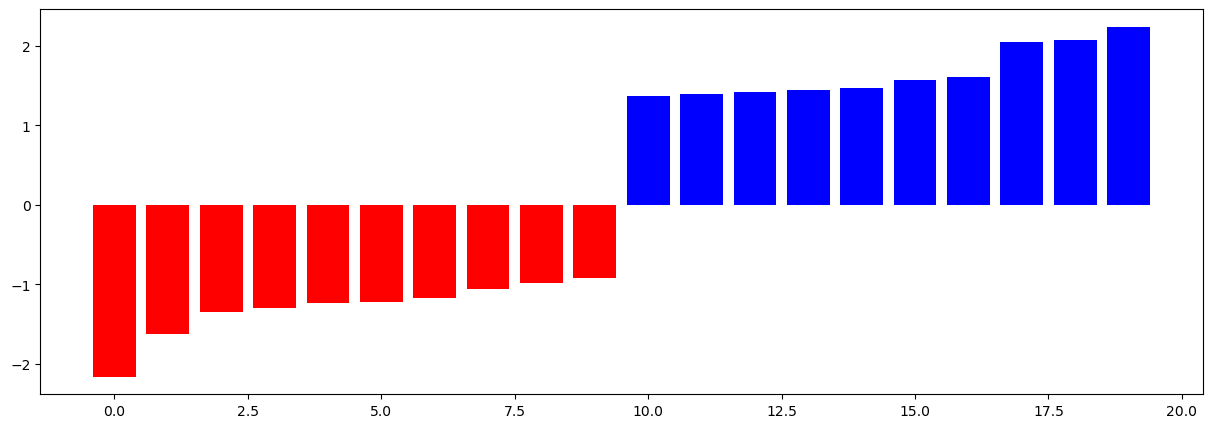

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the most important features for a specific class
def plot_most_important_features(class_idx, top_n=10):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    class_coef = lr_multinomial.coef_[class_idx]

    top_positive_coefficients = np.argsort(class_coef)[-top_n:]
    top_negative_coefficients = np.argsort(class_coef)[:top_n]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in class_coef[top_coefficients]]
    plt.bar(np.arange(2 * top_n), class_coef[top_coefficients], color=colors)
    plt.xticks(np.arange(1, 1 + 2 * top_n), feature_names[top_coefficients], rotation=60, ha="right")
    plt.title(f"Top {top_n} positive and negative influential features for class {class_idx}")
    plt.show()
    return feature_names, class_coef, top_coefficients
# Plotting the features for one of the classes, for example, class 0
feature_names, class_coef,top_coefficients  = plot_most_important_features(1)


In [36]:
top_coefficients

array([5958, 5966, 1743, 7587, 1740, 2342, 3870, 1564, 5965, 4387, 3789,
       5062,  398,  594, 5212, 5628, 2607, 5627, 2590,  401])

In [29]:
import numpy as np

# For each class (emotion), print the top 10 features with the highest coefficients
for i, class_label in enumerate(class_coef):
    top_features = np.argsort(class_coef[i])[-10:]
    print(f"Top features for class {class_label}: {feature_names[top_features]}")


Top features for class -0.09060938847677863: ['08']
Top features for class 0.5414554562846579: ['08']
Top features for class 0.19585191198397137: ['08']
Top features for class 0.07037462701208426: ['08']
Top features for class -0.2057029268785432: ['08']
Top features for class -0.08932055710861515: ['08']
Top features for class -0.04134309142932694: ['08']
Top features for class -0.04733825793888391: ['08']
Top features for class -0.008661988718104413: ['08']
Top features for class 0.06391322711878607: ['08']
Top features for class -0.08514502106732927: ['08']
Top features for class 0.052583330653565886: ['08']
Top features for class 0.1334236245573504: ['08']
Top features for class 0.23667779660860028: ['08']
Top features for class -0.02339931085615694: ['08']
Top features for class -0.03228872134767248: ['08']
Top features for class -0.10630589377154585: ['08']
Top features for class 0.18593401055589934: ['08']
Top features for class -0.04134309142932694: ['08']
Top features for clas

# Testing!

In [287]:
np.random.seed(400)
test_sentiments = add_sentiment_scores(test_texts)

#  extract the sentiment scores into separate arrays, similar to the training set
test_neg_scores = np.array([score['neg'] for score in test_sentiments]).reshape(-1, 1)
test_neu_scores = np.array([score['neu'] for score in test_sentiments]).reshape(-1, 1)
test_pos_scores = np.array([score['pos'] for score in test_sentiments]).reshape(-1, 1)
test_compound_scores = np.array([score['compound'] for score in test_sentiments]).reshape(-1, 1)


# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# `X_train_tfidf` is  original feature matrix from TF-IDF
X_test_augmented = hstack([X_test_tfidf, test_neg_scores, test_neu_scores, test_pos_scores, test_compound_scores])
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_augmented)
X_test_scaled = scaler.transform(X_test_augmented)

# Initialize the Multinomial Logistic Regression model
lr_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model to your training data
lr_multinomial.fit(X_train_augmented, train_labels)

# Validate the model
test_preds = lr_multinomial.predict(X_test_augmented)

# Classification report
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78       558
           1       0.68      0.76      0.72       358
           2       0.87      0.16      0.27       123
           3       0.81      0.60      0.69       382

    accuracy                           0.72      1421
   macro avg       0.76      0.60      0.62      1421
weighted avg       0.74      0.72      0.70      1421



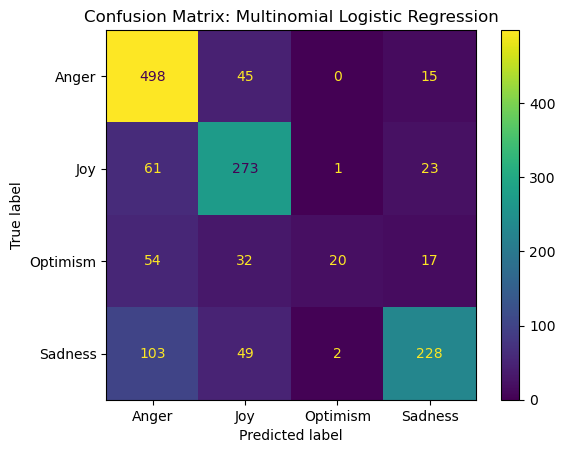

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix for MLR
mlr_cm = confusion_matrix(test_labels, test_preds)
ConfusionMatrixDisplay(mlr_cm, display_labels=["Anger", "Joy", "Optimism", "Sadness"]).plot()
plt.title("Confusion Matrix: Multinomial Logistic Regression")
plt.show()

In [41]:
# Get feature names from the TF-IDF Vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients for each class
class_coefs = lr_multinomial.coef_

# Print top and bottom 5 influential features for each class
num_classes = len(class_coefs)
top_n = 5

for class_idx in range(num_classes):
    print(f"\nTop {top_n} positive influential features for class {class_idx}:")
    top_positive_features = sorted(zip(feature_names, class_coefs[class_idx]), key=lambda x: -x[1])[:top_n]
    for feature, coef in top_positive_features:
        print(f"{feature}: {coef}")

    print(f"\nTop {top_n} negative influential features for class {class_idx}:")
    top_negative_features = sorted(zip(feature_names, class_coefs[class_idx]), key=lambda x: x[1])[:top_n]
    for feature, coef in top_negative_features:
        print(f"{feature}: {coef}")



Top 5 positive influential features for class 0:
angry: 2.5919158899311054
fuck: 2.45357923878927
rag: 2.2194363930375016
fume: 2.1092623465910214
rage: 1.8833236877235238

Top 5 negative influential features for class 0:
sad: -2.7372111258990133
sadness: -2.22440475779965
depression: -2.1998062465479387
worry: -1.8780998301338732
depress: -1.8347289605044654

Top 5 positive influential features for class 1:
hilarious: 2.241330568248952
slang_lol: 2.07717492626689
shake: 2.049488050905854
horror: 1.614605151539119
face_with_tears_of_joy: 1.5658711177088651

Top 5 negative influential features for class 1:
nightmare: -1.627170513978398
optimism: -1.3427539982973173
never: -1.2924638391145067
right: -1.23195982636865
like: -1.2208592893652659

Top 5 positive influential features for class 2:
worry: 2.9621101099470417
fear: 2.8211133239335635
optimism: 2.8155818283647225
start: 1.5923814121794317
quote: 1.3535364228310887

Top 5 negative influential features for class 2:
user: -1.3621187

In [51]:
# Identify misclassified sentences
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels, test_preds)) if true != pred]

# Print misclassified sentences with their true and predicted labels
for index in misclassified_indices:
    print(f"Sentence: {test_texts[index]}")
    print(f"Predicted: {test_preds[index]}, Actual: {test_labels[index]}")
    print("-" * 50)

Sentence: # deppression real partner w/ # depressed people truly not_understand understand depth affect us add # anxiety & ampmakes bad
Predicted: 0, Actual: 3
--------------------------------------------------
Sentence: @ USER @ USER # cmbyn screen august 4 & amp 6 # miff
Predicted: 1, Actual: 3
--------------------------------------------------
Sentence: # amaze watch various news outlet show mixed crowd people watch # eclipse no # racial tension # msm not_hide hide EXCLAMATIONMARK
Predicted: 0, Actual: 1
--------------------------------------------------
Sentence: @ USER @ USER american not_spank spank child god fearing people know big sin hypocrisy
Predicted: 0, Actual: 2
--------------------------------------------------
Sentence: nervous could puke + body temp rise ha ha ha ha ha
Predicted: 3, Actual: 1
--------------------------------------------------
Sentence: not_see see rational way bear grudge not_maybe maybe not_live live netflix not_care care
Predicted: 3, Actual: 0
-----

In [53]:
from collections import Counter
# Define the mapping for the emotion labels
emotion_mapping = {
    0: 'anger',
    1: 'joy',
    2: 'optimism',
    3: 'sadness'
}
# Count the occurrences of each emotion
label_counts = Counter(train_labels)

# Map the counts to the corresponding emotion names
emotion_counts = {emotion_mapping[key]: value for key, value in label_counts.items()}

# Print the counts for each emotion
print(emotion_counts)

{'optimism': 294, 'anger': 1400, 'joy': 708, 'sadness': 855}


# task 1.2

# Now trying following lab

In [53]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
from gensim.utils import tokenize
import gensim.downloader
import matplotlib.pyplot as plt
import torch

In [56]:
def tok_text(sample):
    sample["tokens"] = list(tokenize(sample['text']))
    return sample

tok_train_dataset = train_dataset.map(tok_text)

tok_train_dataset

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 3257
})

In [57]:
from gensim.corpora import Dictionary

dictionary = Dictionary(tok_train_dataset["tokens"]) # construct word<->id mappings - it does it in alphabetical order
print(dictionary)

Dictionary<9310 unique tokens: ['Joyce', 'Meyer', 'Worry', 'a', 'down']...>


In [58]:
dictionary.token2id['a'] + 1  # get input_id for the token "a"

4

In [59]:
# tokenize training set and convert to input IDs.
def encode_text(sample):
   
    input_ids = []
    for token in sample["tokens"]:
        if token in dictionary.token2id:  # Skip words that are not in the vocabulary.
            input_ids.append(dictionary.token2id[token] + 1) 
            
    sample['input_ids'] = input_ids 
    return sample

# The map method of the dataset object takes a function as its argument, 
# and applies that function to each document in the dataset.
pre_train_dataset = tok_train_dataset.map(encode_text)
len(pre_train_dataset)  # length of preprocessed training dataset

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

3257

Mean of the document length: 16.516733190052197
Median of the document length: 17.0
Maximum document length: 34


(array([120., 257., 400., 519., 404., 481., 620., 337., 105.,  14.]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <BarContainer object of 10 artists>)

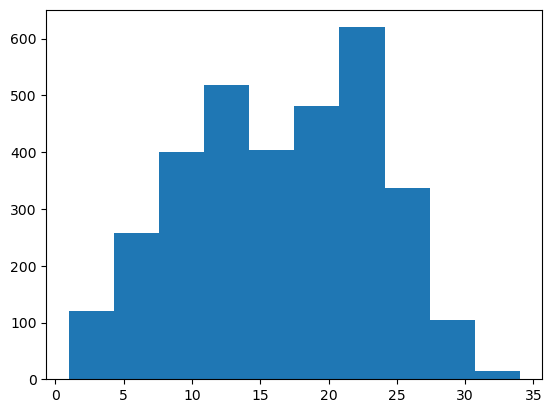

In [60]:
rv_l = [len(doc) for doc in pre_train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

# cleaned up version


Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Epoch 1/20: Train Loss = 1.3495, Train Acc = 37.86%
Val Loss = 1.2928, Val Acc = 42.78%
Epoch 2/20: Train Loss = 1.2433, Train Acc = 43.08%
Val Loss = 1.2281, Val Acc = 43.05%
Epoch 3/20: Train Loss = 1.1654, Train Acc = 46.36%
Val Loss = 1.1053, Val Acc = 49.47%
Epoch 4/20: Train Loss = 1.0293, Train Acc = 56.03%
Val Loss = 1.0149, Val Acc = 57.49%
Epoch 5/20: Train Loss = 0.9096, Train Acc = 65.24%
Val Loss = 0.9902, Val Acc = 61.50%
Epoch 6/20: Train Loss = 0.8048, Train Acc = 70.62%
Val Loss = 0.9351, Val Acc = 62.57%
Epoch 7/20: Train Loss = 0.7110, Train Acc = 73.29%
Val Loss = 0.9003, Val Acc = 65.24%
Epoch 8/20: Train Loss = 0.6263, Train Acc = 77.37%
Val Loss = 0.8518, Val Acc = 65.78%
Epoch 9/20: Train Loss = 0.5684, Train Acc = 80.10%
Val Loss = 0.8549, Val Acc = 67.91%
Epoch 10/20: Train Loss = 0.5035, Train Acc = 83.02%
Val Loss = 0.8762, Val Acc = 65.78%
Epoch 11/20: Train Loss = 0.4482, Train Acc = 85.39%
Val Loss = 0.8766, Val Acc = 66.31%
Epoch 12/20: Train Loss = 0.39

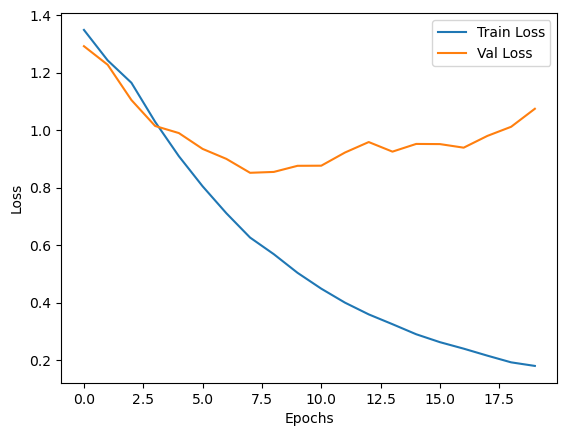

In [243]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from gensim.downloader import load as gensim_load
import emoji
import contractions
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

np.random.seed(400)

# Helper function to map NLTK's POS tags to the format recognized by WordNet Lemmatizer
def nltk_pos_tag_to_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# Slang tagging dictionary (you can expand this list as needed)
slang_dict = {
    'lol': 'SLANG_lol',
    'brb': 'SLANG_brb',
    'btw': 'SLANG_btw',
    'imo': 'SLANG_imo',
    'smh': 'SLANG_smh'
}

def tag_slang(tokens):
    return [slang_dict.get(word, word) for word in tokens]

# Preprocessing function
def preprocess_tweet(text):
    
    # Convert emojis to words
    text = emoji.demojize(text, delimiters=("", " "))
    
    # Lowercase
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Replace URLs, emails, and other patterns with placeholders
    text = re.sub(r"http\S+|www\S+|https\S+", 'URL', text, flags=re.MULTILINE)
    text = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'EMAIL', text)
    text = re.sub(r'\$\d+(?:\.\d+)?', 'MONEY', text)
    text = re.sub(r'\d{10}', 'PHONE', text)
    text = re.sub(r'\d{1,3}%', 'PERCENT', text)
    text = re.sub(r'@\w+', '@USER', text)
    
    # Replace significant punctuation with tokens (preserving emotional punctuation)
    text = text.replace('!', ' EXCLAMATIONMARK ')
    text = text.replace('?', ' QUESTIONMARK ')
    text = re.sub(r'[.,\'"();:]', '', text)  # Remove less informative punctuation
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Tag slang in the tokens
    tokens = tag_slang(tokens)
    
    # Handle negations: if a negation is detected within two words ahead, merge with the negated word
    tokens = [tokens[i] + '_' + tokens[i+1] if tokens[i] in ['not', "n't"] and i+1 < len(tokens) else tokens[i] for i in range(len(tokens)-1)] + [tokens[-1]]
    
    # Lemmatization with POS Tagging
    lemmatizer = WordNetLemmatizer()
    nltk_tagged = pos_tag(tokens)  
    wn_tagged = map(lambda x: (x[0], nltk_pos_tag_to_wordnet_pos(x[1])), nltk_tagged)
    lemmatized_tokens = [lemmatizer.lemmatize(word, tag) if tag is not None else word for word, tag in wn_tagged]
    
    # Remove stopwords, considering negation and other emotionally significant stopwords
    stop_words = set(stopwords.words('english')) - {'not', 'no'}
    filtered_tokens = [word for word in lemmatized_tokens if word not in stop_words]
    
    # Rejoin tokens into a single string
    text = ' '.join(filtered_tokens)
    
    return text

# Tokenize texts and pad sequences
def tok_text(sample):
    sample["tokens"] = list(preprocess_tweet(sample["text"]).split())
    return sample

# Encode text to input IDs based on a dictionary
def encode_text(sample, dictionary):
    input_ids = [dictionary.get(token, 0) + 1 for token in sample["tokens"] if token in dictionary]
    sample["input_ids"] = input_ids
    return sample

# Pad sequences to a fixed length
def pad_text(sample, sequence_length):
    if len(sample["input_ids"]) >= sequence_length:
        sample["input_ids"] = sample["input_ids"][:sequence_length]
    else:
        sample["input_ids"] = [0] * (sequence_length - len(sample["input_ids"])) + sample["input_ids"]
    return sample

# Create a vocabulary from the tokenized texts
def build_vocab(tok_train_dataset):
    all_tokens = [token for tokens in tok_train_dataset["tokens"] for token in tokens]
    vocab = {word: idx for idx, word in enumerate(set(all_tokens))}
    return vocab

# Convert a dataset to a DataLoader
def convert_to_data_loader(dataset, batch_size):
    input_tensor = torch.tensor(np.array(dataset["input_ids"]))
    label_tensor = torch.tensor(np.array(dataset["label"])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# Load datasets using the provided cache directory and preprocess them
cache_dir = "./data_cache"
train_dataset = load_dataset("tweet_eval", name="emotion", split="train", cache_dir=cache_dir)
val_dataset = load_dataset("tweet_eval", name="emotion", split="validation", cache_dir=cache_dir)
test_dataset = load_dataset("tweet_eval", name="emotion", split="test", cache_dir=cache_dir)

# Tokenize the datasets
tok_train_dataset = train_dataset.map(tok_text)
tok_val_dataset = val_dataset.map(tok_text)
tok_test_dataset = test_dataset.map(tok_text)

# Build the vocabulary and encode the datasets
dictionary = build_vocab(tok_train_dataset)
pre_train_dataset = tok_train_dataset.map(lambda sample: encode_text(sample, dictionary))
pre_val_dataset = tok_val_dataset.map(lambda sample: encode_text(sample, dictionary))
pre_test_dataset = tok_test_dataset.map(lambda sample: encode_text(sample, dictionary))

# Pad sequences
sequence_length = 20
pad_train_dataset = pre_train_dataset.map(lambda sample: pad_text(sample, sequence_length))
pad_val_dataset = pre_val_dataset.map(lambda sample: pad_text(sample, sequence_length))
pad_test_dataset = pre_test_dataset.map(lambda sample: pad_text(sample, sequence_length))

# Convert datasets to DataLoader
batch_size = 64
train_loader = convert_to_data_loader(pad_train_dataset, batch_size)
val_loader = convert_to_data_loader(pad_val_dataset, batch_size)
test_loader = convert_to_data_loader(pad_test_dataset, batch_size)

# Load pre-trained GloVe embeddings
glove_wv = gensim_load("glove-twitter-50")
vocab_size = len(dictionary) + 1  # for padding tokens
embedding_size = glove_wv.vector_size
embedding_matrix = torch.zeros((vocab_size, embedding_size))
for word, idx in dictionary.items():
    if word in glove_wv:
        embedding_matrix[idx + 1] = torch.tensor(glove_wv[word], dtype=torch.float)

# Define a simpler LSTM model
class SimplerLSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_layers, sequence_length, num_classes, embedding_matrix):
        super(SimplerLSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm_layer = nn.LSTM(embedding_matrix.shape[1], hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)#, dropout=0.1) #dropout=0.3)
        self.fc_layer = nn.Linear(2 * hidden_size, num_classes)
        #self.dropout = nn.Dropout(0.1)  # Dropout for the fully connected layer
        self.activation = nn.ReLU()

    def forward(self, input_words):
        embedded = self.embedding_layer(input_words)
        _, (z, _) = self.lstm_layer(embedded)
        z = torch.cat((z[0], z[1]), dim=1)
        z = self.activation(z)
        #z = self.dropout(z)  #  dropout here
        output = self.fc_layer(z)
        return output
    
# Initialize the LSTM model
num_layers = 2
hidden_size = 35
num_classes = len(set(train_dataset["label"]))
lstm_model = SimplerLSTMClassifier(hidden_size, num_layers, sequence_length, num_classes, embedding_matrix)

#Train the model and plot learning curves
def train_nn(num_epochs, model, train_dataloader, val_dataloader):
    learning_rate = 0.0005
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    all_train_losses = []
    all_val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        total_correct = 0
        total_trained = 0

        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total_trained += labels.size(0)

        train_accuracy = total_correct / total_trained * 100
        all_train_losses.append(np.mean(train_losses))

        model.eval()
        val_losses = []
        total_correct = 0
        total_trained = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_losses.append(loss.item())
                total_correct += (outputs.argmax(1) == labels).sum().item()
                total_trained += labels.size(0)

        val_accuracy = total_correct / total_trained * 100
        all_val_losses.append(np.mean(val_losses))

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {all_train_losses[-1]:.4f}, Train Acc = {train_accuracy:.2f}%")
        print(f"Val Loss = {all_val_losses[-1]:.4f}, Val Acc = {val_accuracy:.2f}%")

    return model, all_train_losses, all_val_losses

# Train and plot learning curves
num_epochs = 20
trained_model, train_losses, val_losses = train_nn(num_epochs, lstm_model, train_loader, val_loader)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [244]:
# Predict using the trained model on the test set
def predict_nn(trained_model, test_loader):
    trained_model.eval()
    gold_labs, pred_labs = [], []
    for inputs, labels in test_loader:
        outputs = trained_model(inputs)
        gold_labs.extend(labels.tolist())
        pred_labs.extend(outputs.argmax(1).tolist())
    return gold_labs, pred_labs

gold_labs, pred_labs = predict_nn(trained_model, test_loader)


In [245]:
print(classification_report(gold_labs, pred_labs))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       558
           1       0.75      0.57      0.65       358
           2       0.34      0.51      0.41       123
           3       0.65      0.73      0.69       382

    accuracy                           0.68      1421
   macro avg       0.63      0.64      0.63      1421
weighted avg       0.70      0.68      0.69      1421



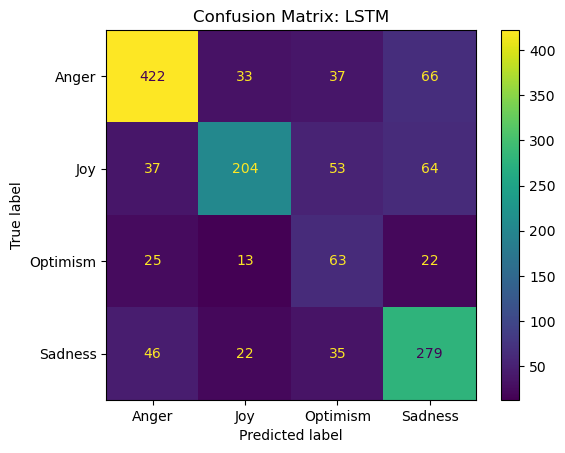

In [246]:
lstm_cm = confusion_matrix(gold_labs, pred_labs)
ConfusionMatrixDisplay(lstm_cm, display_labels=["Anger", "Joy", "Optimism", "Sadness"]).plot()
plt.title("Confusion Matrix: LSTM")
plt.show()

In [256]:
# Function to identify misclassified sentences
def get_misclassified_sentences(test_texts, gold_labs, pred_labs, class_names):
    misclassified = []
    for text, gold, pred in zip(test_texts, gold_labs, pred_labs):
        if gold != pred:
            misclassified.append({
                'sentence': text,
                'actual': class_names[gold],
                'predicted': class_names[pred]
            })
    return misclassified

# Define class names
class_names = ['0', '1', '2', '3']  # Replace with your actual class names


# Find misclassified sentences
misclassified_sentences = get_misclassified_sentences(test_texts, gold_labs, pred_labs, class_names)

# Print the misclassified sentences
for item in misclassified_sentences:
    print(f"Sentence: {item['sentence']}")
    print(f"Predicted: {item['predicted']}, Actual: {item['actual']}")
    print('-' * 50)


Sentence: In need of a change! #restless
Predicted: 0, Actual: 3
--------------------------------------------------
Sentence: @user @user #cmbyn does screen  August 4 &amp; 6 at #miff
Predicted: 2, Actual: 1
--------------------------------------------------
Sentence: @user #shocking loss of talented young man#prayers#pray for his family
Predicted: 3, Actual: 0
--------------------------------------------------
Sentence: That moment when people say you don't need medicine, it's mind over matter. You need to stop doing that. #bipolar
Predicted: 0, Actual: 1
--------------------------------------------------
Sentence: May or may not have just pulled the legal card on these folks. #irritated
Predicted: 0, Actual: 3
--------------------------------------------------
Sentence: Comparing yourself to others is one of the root causes for feelings of unhappiness and depression.
Predicted: 0, Actual: 2
--------------------------------------------------
Sentence: @user @user Americans do not span

In [273]:
import pandas as pd

# Define the tweet text, want to search for
target_tweet = "Every day I dread doing an 8 hour shift in retail 🙂"

# Search for the target tweet in the test set
matching_index = None
for idx, tweet_text in enumerate(test_texts):
    if tweet_text == target_tweet:
        matching_index = idx
        break

if matching_index is not None:
    # Get the corresponding label
    label = test_labels[matching_index]
    print("Found the tweet:")
    print("Tweet:", target_tweet)
    print("Label:", label)
else:
    print("The target tweet was not found in the test set.")

Found the tweet:
Tweet: Every day I dread doing an 8 hour shift in retail 🙂
Label: 3


In [267]:
# Adjusted function to print misclassified tweets
def print_misclassified_tweets(trained_model, test_loader, original_test_texts):
    """
    Print misclassified tweets using the trained model and test loader.

    Args:
        trained_model: The trained LSTM model.
        test_loader: DataLoader object for the test set.
        original_test_texts (list): Original list of tweet texts.
    """
    trained_model.eval()
    gold_labs, pred_labs = [], []

    # Collect predictions and actual labels
    for inputs, labels in test_loader:
        outputs = trained_model(inputs)
        gold_labs.extend(labels.tolist())
        pred_labs.extend(outputs.argmax(1).tolist())

    # Compare and print misclassified tweets
    for idx, (gold, pred) in enumerate(zip(gold_labs, pred_labs)):
        if gold != pred:
            print(f"Tweet: {original_test_texts[idx]}, Predicted Label: {pred}")

# Use the function to print misclassified tweets
print_misclassified_tweets(trained_model, test_loader, test_texts)




Tweet: In need of a change! #restless, Predicted Label: 2
Tweet: @user how can u have sold so many copies but ur game has so many fucking bugs and mad lag issues. Optimize ur shit soon., Predicted Label: 2
Tweet: Pressured. 😦, Predicted Label: 3
Tweet: People who say nmu are the worst, something has to be going on, tell me I wanna know bout your life that's why I fucking asked, I care 😤, Predicted Label: 3
Tweet: @user The hatred from the Left ought to concern everyone----who wants a police state-the left, so than can spy on all of us., Predicted Label: 3
Tweet: I love swimming for the same reason I love meditating...the feeling of weightlessness., Predicted Label: 0
Tweet: When Jim Sheridan is standing next to you and you don't say A WORD!!! #facepalm #tonguetied, Predicted Label: 0
Tweet: @user No #racism, no #hatred , no #sectarianism  ... Only yes to love, Predicted Label: 3
Tweet: @user John, what do you make of DJT's silence? He would usually be foaming at the mouth right now. Ma

In [270]:
# Adjusted function to print misclassified tweets with predicted label 2
def print_misclassified_with_pred_label(trained_model, test_loader, original_test_texts, target_label=2):
    """
    Print misclassified tweets with a specific predicted label.

    Args:
        trained_model: The trained LSTM model.
        test_loader: DataLoader object for the test set.
        original_test_texts (list): Original list of tweet texts.
        target_label (int): Predicted label of interest (default is 2).
    """
    trained_model.eval()
    gold_labs, pred_labs = [], []

    # Collect predictions and actual labels
    for inputs, labels in test_loader:
        outputs = trained_model(inputs)
        gold_labs.extend(labels.tolist())
        pred_labs.extend(outputs.argmax(1).tolist())

    # Compare and print misclassified tweets that match the target predicted label
    for idx, (gold, pred) in enumerate(zip(gold_labs, pred_labs)):
        if gold != pred and pred == target_label:
            print(f"Tweet: {original_test_texts[idx]}, Predicted Label: {pred}")

# Use the function to print misclassified tweets that have a predicted label of 2
print_misclassified_with_pred_label(trained_model, test_loader, test_texts, target_label=2)


Tweet: What makes you feel #joyful?, Predicted Label: 2
Tweet: BUT, I have offended so many people with the idea that conflicts and value judgments are separate that we need to have a talk., Predicted Label: 2
Tweet: @user happy birthday machaaaa 🎈🎉🎊 stay awesome and murah rezeki selalu 👍🏻, Predicted Label: 2
Tweet: #Overheard: 'I don't really like dogs.' I DON'T FEEL SAFE IN THIS PLACE. Clearly a hostile environment!  #bigly #covfefe #TrustNoOne, Predicted Label: 2
Tweet: A woman is sterilised because she is certain that she doesn't want children. What exactly is there to discuss? 😠 #LooseWomen, Predicted Label: 2
Tweet: @user That'll be Madrid throwing a huff over Morata and De Gea. Fuck them, Predicted Label: 2
Tweet: @user OMG poor you! It happened to me last summer. I saw my under skin 😰, Predicted Label: 2
Tweet: @user you look shook! #afraid #shook #impeach #youaregoingdown, Predicted Label: 2
Tweet: My mother-in-law, in a fit of #rage, referred to someone as a 'yo-yo'.\n#yoyo #

found that increasing hidden layers to 30-40 achieved better performance and didnt increase time compexity too much. however doubling this to 64, didnt achieve better results and took far longer. changing hidden layers to just 2 increased perofrmance significantly and reduced time. have foud 2 hidden layers with 35 size and embedding of 50 not 25, works best. No dropout either and no early stopping.

In [62]:
import random
 #Randomly sample 10 misclassified sentences (or fewer if there aren't that many)
random_subset_size = min(10, len(misclassified_sentences))
random_subset = random.sample(misclassified_sentences, random_subset_size)

# Print the random subset of misclassified sentences
for item in random_subset:
    print(f"Sentence: {item['sentence']}")
    print(f"Actual: {item['actual']}, Predicted: {item['predicted']}")
    print('-' * 50)

Sentence: Why is an alarm clock going 'off' when it actually turns on? #alarm #alarmclock #ThursdayThoughts
Actual: 0, Predicted: 3
--------------------------------------------------
Sentence: @user @user @user @user I can't even find tickets anymore gunna call it a day and go cry in the corner I think 😭 lol
Actual: 0, Predicted: 3
--------------------------------------------------
Sentence: The good thing about being a pessimist is that when I have low expectations all the time, I am pleasantly surprised more often. #pessimist
Actual: 3, Predicted: 0
--------------------------------------------------
Sentence: When coming up with banal text to add to things note that 'BE HAPPY' is a lot of god damn pressure!\n#depression #anxiety
Actual: 1, Predicted: 0
--------------------------------------------------
Sentence: @user Goddess, that poor girl 🙁
Actual: 1, Predicted: 0
--------------------------------------------------
Sentence: Humble yourself in the sight of the LORD. If we have died

In [257]:
import pandas as pd

# Define the tweet text you want to search for
target_tweet = "That moment when people say you don't need medicine, it's mind over matter. You need to stop doing that. #bipolar"

# Search for the target tweet in the test set
matching_index = None
for idx, tweet_text in enumerate(test_texts):
    if tweet_text == target_tweet:
        matching_index = idx
        break

if matching_index is not None:
    # Get the corresponding label
    label = test_labels[matching_index]
    print("Found the tweet:")
    print("Tweet:", target_tweet)
    print("Label:", label)
else:
    print("The target tweet was not found in the test set.")



Found the tweet:
Tweet: That moment when people say you don't need medicine, it's mind over matter. You need to stop doing that. #bipolar
Label: 0


In [67]:
# Function to find most similar words
# Find most similar words for "happy" using GloVe embeddings
glove_similar_words = glove_wv.most_similar("anger", topn=10)
print("Most similar words to 'anger' using GloVe embeddings:")
for word, similarity in glove_similar_words:
    print(f"{word}: {similarity}")



Most similar words to 'anger' using GloVe embeddings:
frustration: 0.8830163478851318
emotions: 0.8774688243865967
hatred: 0.840776264667511
sadness: 0.8311312198638916
jealousy: 0.8253424763679504
fear: 0.8236814141273499
emotion: 0.8184413313865662
feelings: 0.8085054159164429
guilt: 0.8039275407791138
grief: 0.8013768196105957


In [288]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assume `tfidf_vectorizer` is your already fitted TF-IDF vectorizer
# and `lr_multinomial` is your trained logistic regression model

# Extract the vocabulary and model coefficients
vocab = tfidf_vectorizer.vocabulary_
lr_coefficients = lr_multinomial.coef_

# Define a function to find most similar words based on logistic regression weights
def most_similar_words_lr(target_word, topn=10):
    if target_word not in vocab:
        print(f"'{target_word}' not found in vocabulary.")
        return []

    # Retrieve the index of the target word in the vocabulary
    target_index = vocab[target_word]

    # Get the feature vector (coefficients) for the target word
    target_vector = lr_coefficients[:, target_index]

    # Calculate cosine similarity with all other words
    similarities = cosine_similarity(target_vector.reshape(1, -1), lr_coefficients.T).flatten()

    # Get the indices of the top-n most similar words (excluding itself)
    most_similar_indices = similarities.argsort()[-(topn + 1):-1][::-1]

    # Retrieve the corresponding words from the vocabulary
    reverse_vocab = {idx: word for word, idx in vocab.items()}
    most_similar_words = [(reverse_vocab[i], similarities[i]) for i in most_similar_indices]

    return most_similar_words

# Example usage to find words most similar to "anger"
similar_words = most_similar_words_lr("anger", topn=10)
print("Most similar words to 'anger' using MLR embeddings:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")


Most similar words to 'anger' using MLR embeddings:
book: 0.9997713937152488
racism: 0.9993690367557306
pakistan: 0.994941159283236
stupid: 0.9945458239863885
resent: 0.9935577389207618
shoot: 0.99331163828894
fan: 0.992439821704858
rise: 0.9923208498847299
answer: 0.9912252719319747
fury: 0.9901217135462781


# 1.4 LDA

In [98]:
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import re

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Custom stop words specific to the domain
custom_stopwords = set(['user', 'http', 'https', 'rt', 'www','amp'])

# Combine all stop words
all_stopwords = STOPWORDS.union(custom_stopwords)

# Regular expressions for pattern matching
url_pattern = re.compile(r'https?://\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
number_pattern = re.compile(r'\d+')

def preprocess(text):
    # Remove URLs, user mentions, and numbers
    text = url_pattern.sub('', text)
    text = mention_pattern.sub('', text)
    text = number_pattern.sub('', text)

    result = []
    # Tokenize, lemmatize, and remove stop words, while keeping hashtags
    for token in simple_preprocess(text):
        if token not in all_stopwords or token.startswith('#'):
            result.append(lemmatizer.lemmatize(token, 'v'))  # Use 'v' (verb) for lemmatization
    return result


In [99]:
processed = []
for tweet in train_texts:
    processed.append(preprocess(tweet))

In [100]:
from gensim.corpora import Dictionary

dictionary = Dictionary(processed) # construct word<->id mappings - it does it in alphabetical order
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary<6638 unique tokens: ['joyce', 'leadership', 'meyer', 'motivation', 'payment']...>


In [101]:
from gensim.models import LdaModel

# This call will construct and fit (train) the LDA model:
lda_model =  LdaModel(bow_corpus, 
                      num_topics=4, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

In [102]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.013*"like" + 0.008*"feel" + 0.007*"play" + 0.007*"time" + 0.006*"think" + 0.005*"angry" + 0.005*"fuck" + 0.005*"lose" + 0.005*"sadness" + 0.004*"rage"


Topic: 1 
Words: 0.009*"look" + 0.008*"like" + 0.008*"love" + 0.007*"day" + 0.007*"sad" + 0.006*"get" + 0.005*"think" + 0.005*"stop" + 0.004*"lose" + 0.004*"black"


Topic: 2 
Words: 0.009*"people" + 0.008*"know" + 0.007*"fuck" + 0.007*"watch" + 0.007*"like" + 0.006*"let" + 0.006*"live" + 0.006*"start" + 0.005*"want" + 0.005*"fear"


Topic: 3 
Words: 0.007*"go" + 0.006*"work" + 0.006*"get" + 0.005*"awful" + 0.005*"blue" + 0.004*"worry" + 0.004*"ve" + 0.004*"think" + 0.004*"want" + 0.004*"hilarious"




In [103]:
# Set the index below to choose a document:
test_document_idx = 0
# Retrieve the document and print its newsgroup:
unseen_document = test_texts[test_document_idx]
print(unseen_document)
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

# Assuming 'bow_vector' contains pairs (word_id, count) after preprocessing:
for idx, count in bow_vector:
    print(f'{dictionary[idx]}: {count}')


#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse
depress: 1
make: 1
people: 1
anxiety: 1
worse: 1
truly: 1
understand: 1
dont: 1
real: 1
depth: 1
add: 1
affect: 1
partner: 1


In [104]:
topic_distribution = lda_model[bow_vector]

In [105]:
for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model.print_topic(index, 5)))

Index: 2
Probability: 0.27890118956565857	 Topic: 0.009*"people" + 0.008*"know" + 0.007*"fuck" + 0.007*"watch" + 0.007*"like"
Index: 1
Probability: 0.2770426571369171	 Topic: 0.009*"look" + 0.008*"like" + 0.008*"love" + 0.007*"day" + 0.007*"sad"
Index: 3
Probability: 0.2727300822734833	 Topic: 0.007*"go" + 0.006*"work" + 0.006*"get" + 0.005*"awful" + 0.005*"blue"
Index: 0
Probability: 0.17132608592510223	 Topic: 0.013*"like" + 0.008*"feel" + 0.007*"play" + 0.007*"time" + 0.006*"think"


# bigrams and filterinng extremes attempt

In [118]:
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.corpora import Dictionary
import re

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Custom stop words specific to the domain
custom_stopwords = set(['user', 'http', 'https', 'rt', 'www', 'amp'])

# Combine all stop words
all_stopwords = STOPWORDS.union(custom_stopwords)

# Regular expressions for pattern matching
url_pattern = re.compile(r'https?://\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
number_pattern = re.compile(r'\d+')

def preprocess(text):
    # Remove URLs, user mentions, and numbers
    text = url_pattern.sub('', text)
    text = mention_pattern.sub('', text)
    text = number_pattern.sub('', text)

    result = []
    # Tokenize, lemmatize, and remove stop words, while keeping hashtags
    for token in simple_preprocess(text):
        if token not in all_stopwords or token.startswith('#'):
            result.append(lemmatizer.lemmatize(token, 'v'))  # Use 'v' (verb) for lemmatization
    return result

# Preprocess texts
processed = [preprocess(tweet) for tweet in train_texts]

# Train the Phrases model directly on the preprocessed corpus
phrases = Phrases(processed, min_count=2, threshold=5, connector_words=ENGLISH_CONNECTOR_WORDS)

# Apply the trained Phrases model to the corpus to form bigrams
processed_bigrams = [phrases[sentence] for sentence in processed]

# Construct a dictionary using the bigrammed texts
dictionary = Dictionary(processed_bigrams)

# Filter extremes to remove less common or overly frequent words
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Adjust `no_below` and `no_above` as needed

# Create a bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_bigrams]

# Print the dictionary for verification
print(dictionary)



Dictionary<991 unique tokens: ['problem', 'worry', 'okay', 'terrible', 'cute']...>


In [201]:
# Copy the dictionary before filtering (for comparison)
pre_filter_dictionary = Dictionary(processed_bigrams)

# Apply filter_extremes to your original dictionary
dictionary.filter_extremes(no_below=10)

# Function to check if a word exists in a dictionary
def check_word_in_dictionary(word, dictionary):
    if word in dictionary.token2id:
        print(f"'{word}' is still in the dictionary with token ID: {dictionary.token2id[word]}")
    else:
        print(f"'{word}' has been removed from the dictionary")

# Check if the word "user" is still present
check_word_in_dictionary("user", dictionary)

# Optional: Compare the size of the dictionaries
print(f"Original Dictionary Size: {len(pre_filter_dictionary)}")
print(f"Filtered Dictionary Size: {len(dictionary)}")


'user' is still in the dictionary with token ID: 19
Original Dictionary Size: 6835
Filtered Dictionary Size: 454


In [202]:
# Create a copy of the original dictionary
original_dictionary = Dictionary(processed_bigrams)

# Apply filter_extremes to your original dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Find the words that were removed
removed_words = set(original_dictionary.token2id.keys()) - set(dictionary.token2id.keys())

# Print a sample of removed words
print("Sample of Removed Words:", list(removed_words)[:20])


Sample of Removed Words: ['reflect', 'indvsnz', 'goddamn', 'chalk', 'marcus', 'fuel', 'reply', 'vest', 'cept', 'ios', 'swoop', 'wasteland', 'desire', 'sangria', 'slag', 'blaiming', 'gottawearshades', 'turnovers', 'csgo', 'hoys']


In [223]:


# Now filtered_train_texts contains only the tweets labeled 1 or 2

# Add "user" to the stop word list if not already present
custom_stopwords = set(['user','amp'])
all_stopwords = STOPWORDS.union(custom_stopwords)

def preprocess(text):
    # Apply stop word filtering including custom stop words
    result = []
    for token in simple_preprocess(text):
        if token not in all_stopwords:
            result.append(lemmatizer.lemmatize(token, 'v'))
    return result

            
    return result
# Preprocess texts
processed = [preprocess(tweet) for tweet in train_texts]

# Train the Phrases model directly on the preprocessed corpus
phrases = Phrases(processed, min_count=2, threshold=5, connector_words=ENGLISH_CONNECTOR_WORDS)

# Apply the trained Phrases model to the corpus to form bigrams
processed_bigrams = [phrases[sentence] for sentence in processed]

# Construct a dictionary using the bigrammed texts
dictionary = Dictionary(processed_bigrams)

# Filter extremes to remove less common or overly frequent words
#dictionary.filter_extremes(no_below=5, no_above=0.5)  # Adjust `no_below` and `no_above` as needed

# Create a bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_bigrams]

# Print the dictionary for verification
print(dictionary)


Dictionary<6829 unique tokens: ['joyce', 'leadership_worry', 'meyer', 'motivation', 'payment']...>


In [204]:
# Check if "jazz" is in the dictionary and print the result
word_to_check = "jazz"
if word_to_check in dictionary.token2id:
    print(f"'{word_to_check}' is in the dictionary with token ID: {dictionary.token2id[word_to_check]}")
else:
    print(f"'{word_to_check}' is not in the dictionary")


'jazz' is in the dictionary with token ID: 6158


In [177]:
# Print some of the processed bigrams to verify the results
for i, bigram in enumerate(processed_bigrams[:50]):
    print(f"Original Sentence {i + 1}: {processed[i]}")
    print(f"Processed with Bigrams {i + 1}: {bigram}\n")


Original Sentence 1: ['worry', 'payment', 'problem', 'joyce', 'meyer', 'motivation', 'leadership', 'worry']
Processed with Bigrams 1: ['worry', 'payment', 'problem', 'joyce', 'meyer', 'motivation', 'leadership_worry']

Original Sentence 2: ['roommate', 'okay', 'spell', 'autocorrect', 'terrible', 'firstworldprobs']
Processed with Bigrams 2: ['roommate', 'okay', 'spell', 'autocorrect', 'terrible', 'firstworldprobs']

Original Sentence 3: ['cute', 'atsu', 'probably', 'shy', 'photos', 'cherry', 'help', 'uwu']
Processed with Bigrams 3: ['cute', 'atsu', 'probably', 'shy', 'photos', 'cherry', 'help', 'uwu']

Original Sentence 4: ['rooneys', 'fuck', 'untouchable', 'isn', 'fuck', 'dreadful', 'depay', 'look', 'decent', 'ish', 'tonight']
Processed with Bigrams 4: ['rooneys', 'fuck', 'untouchable', 'isn', 'fuck_dreadful', 'depay', 'look', 'decent', 'ish', 'tonight']

Original Sentence 5: ['pretty', 'depress', 'hit', 'pan', 'ur', 'favourite', 'highlighter']
Processed with Bigrams 5: ['pretty', 'dep

In [123]:
from gensim.models import HdpModel

### WRITE YOUR OWN CODE HERE
hdp_model = HdpModel(bow_corpus, 
                     id2word=dictionary,
                     alpha=0.0001,
                     gamma=100)

###

# print the word-topic distributions for 
for idx, topic in hdp_model.print_topics(20):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.008*age + 0.008*super + 0.008*horror_movie + 0.006*hair + 0.005*dull + 0.005*grieve + 0.005*gonna + 0.004*feel_like + 0.004*bear + 0.004*shit


Topic: 1 
Words: 0.008*dark + 0.008*live_ly + 0.006*white_people + 0.006*sulk + 0.006*dear + 0.005*send + 0.005*open + 0.005*fuck + 0.005*lie + 0.005*respond


Topic: 2 
Words: 0.008*blood + 0.008*suggest + 0.007*fret + 0.007*internet + 0.006*nation + 0.006*video + 0.006*jesus + 0.006*send + 0.006*birthday + 0.005*arrive


Topic: 3 
Words: 0.007*bore + 0.006*new + 0.006*jesus + 0.006*make + 0.005*policy + 0.005*soon + 0.005*sorry + 0.005*manchester + 0.005*sadness + 0.004*dude


Topic: 4 
Words: 0.007*american + 0.007*website + 0.006*provoke + 0.005*secret + 0.005*sober + 0.005*order + 0.005*replace + 0.005*happy_birthday + 0.005*place + 0.004*fuel


Topic: 5 
Words: 0.009*ill + 0.007*blue + 0.006*football + 0.006*ready + 0.006*store + 0.006*nervous + 0.005*slow + 0.005*problems + 0.005*cloud + 0.005*delight


Topic: 6 
Words

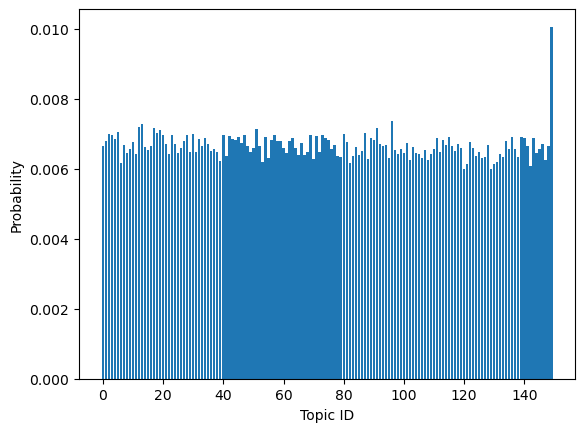

In [124]:
def plot_global_topic_weights(hdp_model):
    global_topic_weights = hdp_model.m_varphi_ss / np.sum(hdp_model.m_varphi_ss)

    plt.bar(np.arange(len(global_topic_weights)), global_topic_weights)
    plt.ylabel('Probability')
    plt.xlabel('Topic ID')
    
plot_global_topic_weights(hdp_model)

In [240]:
# Filter train_texts based on train_labels
filtered_train_texts = [train_texts[i] for i, label in enumerate(train_labels) if label in [1, 2]]

# Now filtered_train_texts contains only the tweets labeled 1 or 2

# Add "user" to the stop word list if not already present
custom_stopwords = set(['user','amp'])
all_stopwords = STOPWORDS.union(custom_stopwords)

def preprocess(text):
    # Apply stop word filtering including custom stop words
    result = []
    for token in simple_preprocess(text):
        if token not in all_stopwords:
            result.append(lemmatizer.lemmatize(token, 'v'))
    return result

            
    return result
# Preprocess texts
processed = [preprocess(tweet) for tweet in filtered_train_texts]

# Train the Phrases model directly on the preprocessed corpus
phrases = Phrases(processed, min_count=2, threshold=5, connector_words=ENGLISH_CONNECTOR_WORDS)

# Apply the trained Phrases model to the corpus to form bigrams
processed_bigrams = [phrases[sentence] for sentence in processed]

# Construct a dictionary using the bigrammed texts
dictionary = Dictionary(processed_bigrams)

# Filter extremes to remove less common or overly frequent words
#dictionary.filter_extremes(no_below=5, no_above=0.5)  # Adjust `no_below` and `no_above` as needed

# Create a bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_bigrams]

# Print the dictionary for verification
print(dictionary)


Dictionary<3217 unique tokens: ['joyce', 'leadership_worry', 'meyer', 'motivation', 'payment']...>


In [241]:
from gensim.models import LdaModel

# This call will construct and fit (train) the LDA model:
lda_model =  LdaModel(bow_corpus, 
                      num_topics=30, 
                      id2word=dictionary,                                    
                      passes=10,
                      random_state=400
                    ) 

In [242]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.014*"thank" + 0.012*"anxiety" + 0.009*"night" + 0.009*"new" + 0.006*"hear" + 0.006*"want" + 0.006*"horror" + 0.006*"follow" + 0.006*"house" + 0.006*"play"


Topic: 1 
Words: 0.033*"watch_amaze" + 0.033*"live_ly" + 0.033*"musically" + 0.033*"broadcast_lively" + 0.014*"life" + 0.014*"day" + 0.011*"morning" + 0.011*"good" + 0.008*"follow" + 0.006*"literally"


Topic: 2 
Words: 0.041*"smile" + 0.013*"take" + 0.010*"start" + 0.009*"lips" + 0.009*"nd" + 0.009*"love" + 0.009*"lot" + 0.006*"chance" + 0.006*"horrible" + 0.006*"hit"


Topic: 3 
Words: 0.022*"fear" + 0.015*"get" + 0.012*"milk" + 0.012*"day" + 0.012*"want" + 0.012*"excite" + 0.010*"start" + 0.010*"eye" + 0.010*"quote" + 0.007*"life"


Topic: 4 
Words: 0.012*"szn" + 0.009*"let" + 0.009*"yo" + 0.009*"st" + 0.009*"year" + 0.006*"thank" + 0.006*"gt" + 0.006*"better" + 0.006*"century" + 0.006*"gt_gt"


Topic: 5 
Words: 0.016*"good" + 0.016*"know" + 0.010*"love" + 0.010*"tree" + 0.010*"shake" + 0.008*"cross" + 0.008*"

In [209]:
from gensim.models import Phrases, LdaModel, CoherenceModel

def find_best_num_topics(min_topics, max_topics, step, bow_corpus, dictionary, texts):
    best_coherence = 0
    best_model = None
    best_num_topics = 0
    coherence_scores = {}

    for num_topics in range(min_topics, max_topics + 1, step):
        lda_model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=num_topics, random_state=42, alpha='auto', eta='auto')
        
        # Calculate coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        
        # Store the coherence score for this topic number
        coherence_scores[num_topics] = coherence_score
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

        # Check if this model has the best coherence score so far
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_model = lda_model
            best_num_topics = num_topics

    return best_model, best_num_topics, best_coherence, coherence_scores

# Define the range of topics to explore
min_topics = 5
max_topics = 100
step = 5

# Run the function to find the best number of topics
best_lda_model, best_num_topics, best_coherence, all_coherence_scores = find_best_num_topics(min_topics, max_topics, step, bow_corpus, dictionary, processed_bigrams)

print(f"Best Number of Topics: {best_num_topics}, Coherence Score: {best_coherence}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


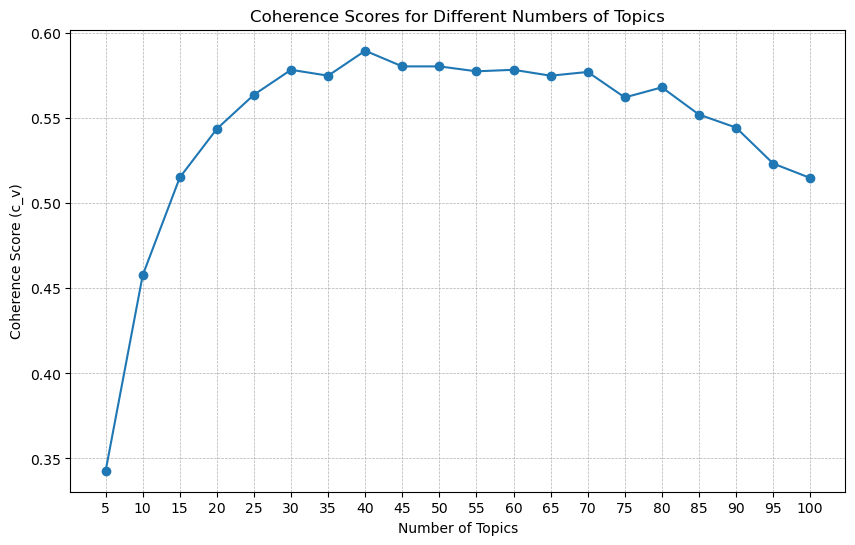

In [210]:
import matplotlib.pyplot as plt

# Function to plot the coherence scores across different numbers of topics
def plot_coherence_scores(coherence_scores):
    # Extract the number of topics and the associated coherence scores
    num_topics = list(coherence_scores.keys())
    scores = list(coherence_scores.values())

    # Plot the coherence scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics, scores, marker='o', linestyle='-')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.title("Coherence Scores for Different Numbers of Topics")
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.xticks(num_topics)  # Set x-ticks to correspond to each topic count
    plt.show()

# Plot the coherence scores using the function
plot_coherence_scores(all_coherence_scores)


As HDA did not work but located over 140 topics, I turned to LDA. as there are 4 emotions in the dataset i started with 4 topics. This did not yield very coherent topics, as they contained a lot of crossover and didnt have clear themes. As I increased the number of topics, I saw more granular groups emerging. I used the concept of Coherence score to test these topics and made a for loop function which tested the coherence for a range of topic numbers. It was found that 35-40 topics achieved the best results, and I opted for the lower value to balance fine granularity. I also tested the dud result from HDA and found that 140 topics did not get a better coherence. 

In [214]:
pip install textblob


DEPRECATION: Loading egg at /Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/huggingface_hub-0.21.3-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 10.6 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [219]:
# Define a custom positive lexicon
custom_positive_lexicon = {
    "happy", "joy", "love", "cheer", "optimistic", "great", "good", "celebrate", "smile", "excited"
}

def assess_topic_with_lexicon(topic_words, positive_lexicon):
    """
    Checks if a topic contains a significant number of positive words.
    Returns the count of positive words and a boolean indicating positivity.
    """
    positive_count = sum(1 for word, _ in topic_words if word in positive_lexicon)
    is_positive = positive_count > 0  # Define positivity by at least one positive word present
    return positive_count, is_positive

def analyze_topics_with_lexicon(lda_model, num_topics, positive_lexicon):
    """
    Analyzes the topics using the custom positive lexicon to classify them as positive or not.
    """
    topic_classification = {}

    for topic_num in range(num_topics):
        topic_terms = lda_model.show_topic(topic_num, topn=10)
        positive_count, is_positive = assess_topic_with_lexicon(topic_terms, positive_lexicon)
        sentiment_type = "Positive" if is_positive else "Not Positive"
        topic_classification[topic_num] = (sentiment_type, positive_count)
        print(f"Topic {topic_num}: Sentiment - {sentiment_type} (Positive Count: {positive_count})")
    
    return topic_classification

# Example analysis using the custom lexicon
num_topics = 30  
positive_topic_classification = analyze_topics_with_lexicon(lda_model, num_topics, custom_positive_lexicon)


Topic 0: Sentiment - Positive (Positive Count: 3)
Topic 1: Sentiment - Positive (Positive Count: 1)
Topic 2: Sentiment - Not Positive (Positive Count: 0)
Topic 3: Sentiment - Not Positive (Positive Count: 0)
Topic 4: Sentiment - Not Positive (Positive Count: 0)
Topic 5: Sentiment - Not Positive (Positive Count: 0)
Topic 6: Sentiment - Not Positive (Positive Count: 0)
Topic 7: Sentiment - Not Positive (Positive Count: 0)
Topic 8: Sentiment - Positive (Positive Count: 1)
Topic 9: Sentiment - Positive (Positive Count: 1)
Topic 10: Sentiment - Not Positive (Positive Count: 0)
Topic 11: Sentiment - Not Positive (Positive Count: 0)
Topic 12: Sentiment - Positive (Positive Count: 1)
Topic 13: Sentiment - Not Positive (Positive Count: 0)
Topic 14: Sentiment - Not Positive (Positive Count: 0)
Topic 15: Sentiment - Not Positive (Positive Count: 0)
Topic 16: Sentiment - Not Positive (Positive Count: 0)
Topic 17: Sentiment - Not Positive (Positive Count: 0)
Topic 18: Sentiment - Positive (Positive

In [216]:
from textblob import TextBlob

def assess_topic_sentiment(topic_words):
    """
    Given a list of topic words, returns the sentiment polarity score.
    """
    # Join all words into a single string for analysis
    topic_text = " ".join([word for word, _ in topic_words])
    # Analyze the sentiment of the topic text
    sentiment_score = TextBlob(topic_text).sentiment.polarity
    return sentiment_score

def analyze_topic_sentiments(lda_model, num_topics):
    """
    Analyzes the sentiments of each topic generated by the LDA model.
    """
    topic_sentiments = {}

    # Retrieve the top words for each topic
    for topic_num in range(num_topics):
        topic_terms = lda_model.show_topic(topic_num, topn=10)  # Top 10 words per topic
        sentiment = assess_topic_sentiment(topic_terms)
        sentiment_type = "Positive" if sentiment > 0 else "Negative" if sentiment < 0 else "Neutral"
        topic_sentiments[topic_num] = (sentiment_type, sentiment)
        print(f"Topic {topic_num}: Sentiment - {sentiment_type} (Score: {sentiment})")
    
    return topic_sentiments

# Use this function to analyze sentiments of your topics
num_topics = 30  # Example number of topics from your LDA model
topic_sentiments = analyze_topic_sentiments(lda_model, num_topics)



Topic 0: Sentiment - Positive (Score: 0.26666666666666666)
Topic 1: Sentiment - Negative (Score: -0.0854166666666667)
Topic 2: Sentiment - Negative (Score: -0.45)
Topic 3: Sentiment - Positive (Score: 0.22083333333333333)
Topic 4: Sentiment - Negative (Score: -0.6333333333333333)
Topic 5: Sentiment - Positive (Score: 0.35000000000000003)
Topic 6: Sentiment - Negative (Score: -0.40625)
Topic 7: Sentiment - Negative (Score: -0.20000000000000004)
Topic 8: Sentiment - Positive (Score: 0.8)
Topic 9: Sentiment - Positive (Score: 0.033333333333333326)
Topic 10: Sentiment - Negative (Score: -0.3)
Topic 11: Sentiment - Positive (Score: 0.03392857142857142)
Topic 12: Sentiment - Negative (Score: -0.25)
Topic 13: Sentiment - Neutral (Score: 0.0)
Topic 14: Sentiment - Negative (Score: -0.4833333333333333)
Topic 15: Sentiment - Neutral (Score: 0.0)
Topic 16: Sentiment - Neutral (Score: 0.0)
Topic 17: Sentiment - Negative (Score: -0.16666666666666666)
Topic 18: Sentiment - Positive (Score: 0.4)
Topi

In [217]:
from collections import defaultdict

def collect_positive_tweets(lda_model, bow_corpus, processed_bigrams, positive_topics):
    """
    Collects all tweets that have a significant association with any positive topics.
    """
    positive_tweets = defaultdict(list)
    
    for i, bow in enumerate(bow_corpus):
        # Get the topics for this document
        topics = lda_model.get_document_topics(bow, minimum_probability=0.0)

        # Check if any topic for this tweet belongs to positive topics
        for topic_num, prob in topics:
            if topic_num in positive_topics and prob > 0.1:  # Example threshold to ensure significance
                positive_tweets[topic_num].append(processed_bigrams[i])
                break

    return positive_tweets


positive_topics = [topic_num for topic_num, (sentiment_type, _) in topic_sentiments.items() if sentiment_type == "Positive"]

# Collect all tweets associated with positive topics
positive_tweets = collect_positive_tweets(best_lda_model, bow_corpus, processed_bigrams, positive_topics)

# Further Analysis on Positive Tweets
def analyze_overarching_themes(positive_tweets):
    """
    Analyzes overarching themes by inspecting the most frequent words in positive tweets.
    """
    from collections import Counter
    all_words = []

    # Combine words from all positive tweets
    for topic_tweets in positive_tweets.values():
        for tweet in topic_tweets:
            all_words.extend(tweet)

    # Count the frequency of each word
    word_freq = Counter(all_words)

    # Print out the 20 most common words as overarching themes
    common_words = word_freq.most_common(20)
    print("Most Common Words in Positive Tweets (Themes):")
    for word, count in common_words:
        print(f"{word}: {count}")

# Perform the theme analysis
analyze_overarching_themes(positive_tweets)


Most Common Words in Positive Tweets (Themes):
like: 90
think: 76
people: 64
know: 63
get: 62
fuck: 62
sad: 59
go: 52
love: 50
day: 50
feel: 49
time: 49
look: 46
watch: 46
say: 45
life: 43
want: 42
depress: 41
good: 41
tell: 41


In [218]:
import random

def collect_positive_tweets(lda_model, bow_corpus, processed_bigrams, positive_topics):
    """
    Collects all tweets that have a significant association with any positive topics.
    """
    positive_tweets = defaultdict(list)
    
    for i, bow in enumerate(bow_corpus):
        # Get the topics for this document
        topics = lda_model.get_document_topics(bow, minimum_probability=0.0)

        # Check if any topic for this tweet belongs to positive topics
        for topic_num, prob in topics:
            if topic_num in positive_topics and prob > 0.1:  # Example threshold to ensure significance
                positive_tweets[topic_num].append(processed_bigrams[i])
                break

    return positive_tweets

# Example usage to collect positive tweets
positive_topics = [topic_num for topic_num, (sentiment_type, _) in topic_sentiments.items() if sentiment_type == "Positive"]
positive_tweets = collect_positive_tweets(best_lda_model, bow_corpus, processed_bigrams, positive_topics)

def output_positive_tweets(positive_tweets, num_samples=3):
    """
    Prints a sample of tweets for each positive topic.
    """
    for topic_num, tweets in positive_tweets.items():
        # Randomly sample tweets up to the specified number or all if less than `num_samples`
        sampled_tweets = random.sample(tweets, min(num_samples, len(tweets)))
        print(f"\nTopic {topic_num} - Sampled Positive Tweets:")
        for tweet in sampled_tweets:
            print(" ".join(tweet))

# Output an assortment of positive tweets
output_positive_tweets(positive_tweets, num_samples=5)



Topic 29 - Sampled Positive Tweets:
maybe constipation issue know date relieve affliction way jose
impress depress
ha right san jose ca offend right dave walk time
sober say drink teach mouth shut ernest hemingway quote
get hyper predator heckler situation

Topic 5 - Sampled Positive Tweets:
joyful encounter tribez castlez meet bartolomeo want know download game
hope come_haunt maybe know felt_like lowest
country divide approach fight terrorism pakistani terrorism
zero help customer_service push buck forth promise callbacks happen loathe
sure like comparison usa emulate israel methods protect civilians terror_attack

Topic 28 - Sampled Positive Tweets:
hard_tell pic mistake way say initially race take sad ignorant
wish kid stressful gabriella troy hsm
ashamed ally pakistan sacrifice civilians side war terror
look teef growl
ummm blog say simon stehr fake th ll expect investigation forthwith

Topic 23 - Sampled Positive Tweets:
nice texans hold ball fuller hopkins chance awful tnf
stop

In [154]:
pip install pyldavis

DEPRECATION: Loading egg at /Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/huggingface_hub-0.21.3-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 11.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [233]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=dictionary)
vis

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.080026  0.121739       1        1  4.463822
9      0.136239 -0.025885       2        1  4.190490
11     0.058552  0.072948       3        1  4.067063
18     0.054160 -0.051535       4        1  3.907945
27    -0.083358  0.129889       5        1  3.512237
29    -0.012511  0.003070       6        1  3.494749
17     0.102443 -0.145954       7        1  3.481482
15    -0.120805  0.019982       8        1  3.480335
20    -0.122647 -0.088979       9        1  3.468859
3     -0.019205  0.054386      10        1  3.462310
22    -0.068123 -0.064524      11        1  3.453424
5     -0.029567  0.001103      12        1  3.450729
19     0.042373 -0.006770      13        1  3.445810
7     -0.012195 -0.006442      14        1  3.418944
1      0.053812  0.013016      15        1  3.386263
24     0.057028 -0.000798      16        1  3.228183
6     -0.098084  0.073972      17        1  3.204543
13     0.050936  0.000747      18        1  3.203910
12    -0.076740 -0.032979      19        1  3.201577
16     0.044247  0.080026      20        1  3.187045
21     0.075258  0.021813      21        1  3.181873
0     -0.040190 -0.034964      22        1  3.176182
2      0.050321  0.128034      23        1  3.099666
8     -0.050750 -0.072313      24        1  3.018729
26    -0.018854  0.020823      25        1  2.948180
4     -0.014101 -0.087030      26        1  2.874108
28     0.080212 -0.092354      27        1  2.836996
25    -0.043148 -0.051901      28        1  2.814749
10    -0.022469 -0.023642      29        1  2.776888
23    -0.052859  0.044522      30        1  2.562907, topic_info=      Term        Freq       Total Category  logprob  loglift
348   like  154.000000  154.000000  Default  30.0000  30.0000
263   want   82.000000   82.000000  Default  29.0000  29.0000
938   fume   47.000000   47.000000  Default  28.0000  28.0000
510   lose   71.000000   71.000000  Default  27.0000  27.0000
341  anger   45.000000   45.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
23    fuck    5.279903   84.830457  Topic30  -4.7616   0.8873
366    let    4.759557   51.826616  Topic30  -4.8654   1.2763
346    guy    4.223248   43.609246  Topic30  -4.9849   1.3294
968   turn    3.707568   29.465228  Topic30  -5.1151   1.5912
475   need    3.721941   61.788793  Topic30  -5.1113   0.8546

[1647 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2797      8  0.719012  aaaaarrrrgghhh
2128     15  0.830301            able
1866      2  0.120361        absolute
1866     12  0.842530        absolute
881       1  0.125672      absolutely
...     ...       ...             ...
3479     26  0.727238           yo_yo
841      20  0.888666             yrs
3991      1  0.234465            zero
3991     19  0.586162            zero
2648     22  0.745567            zone

[3488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 10, 12, 19, 28, 30, 18, 16, 21, 4, 23, 6, 20, 8, 2, 25, 7, 14, 13, 17, 22, 1, 3, 9, 27, 5, 29, 26, 11, 24])

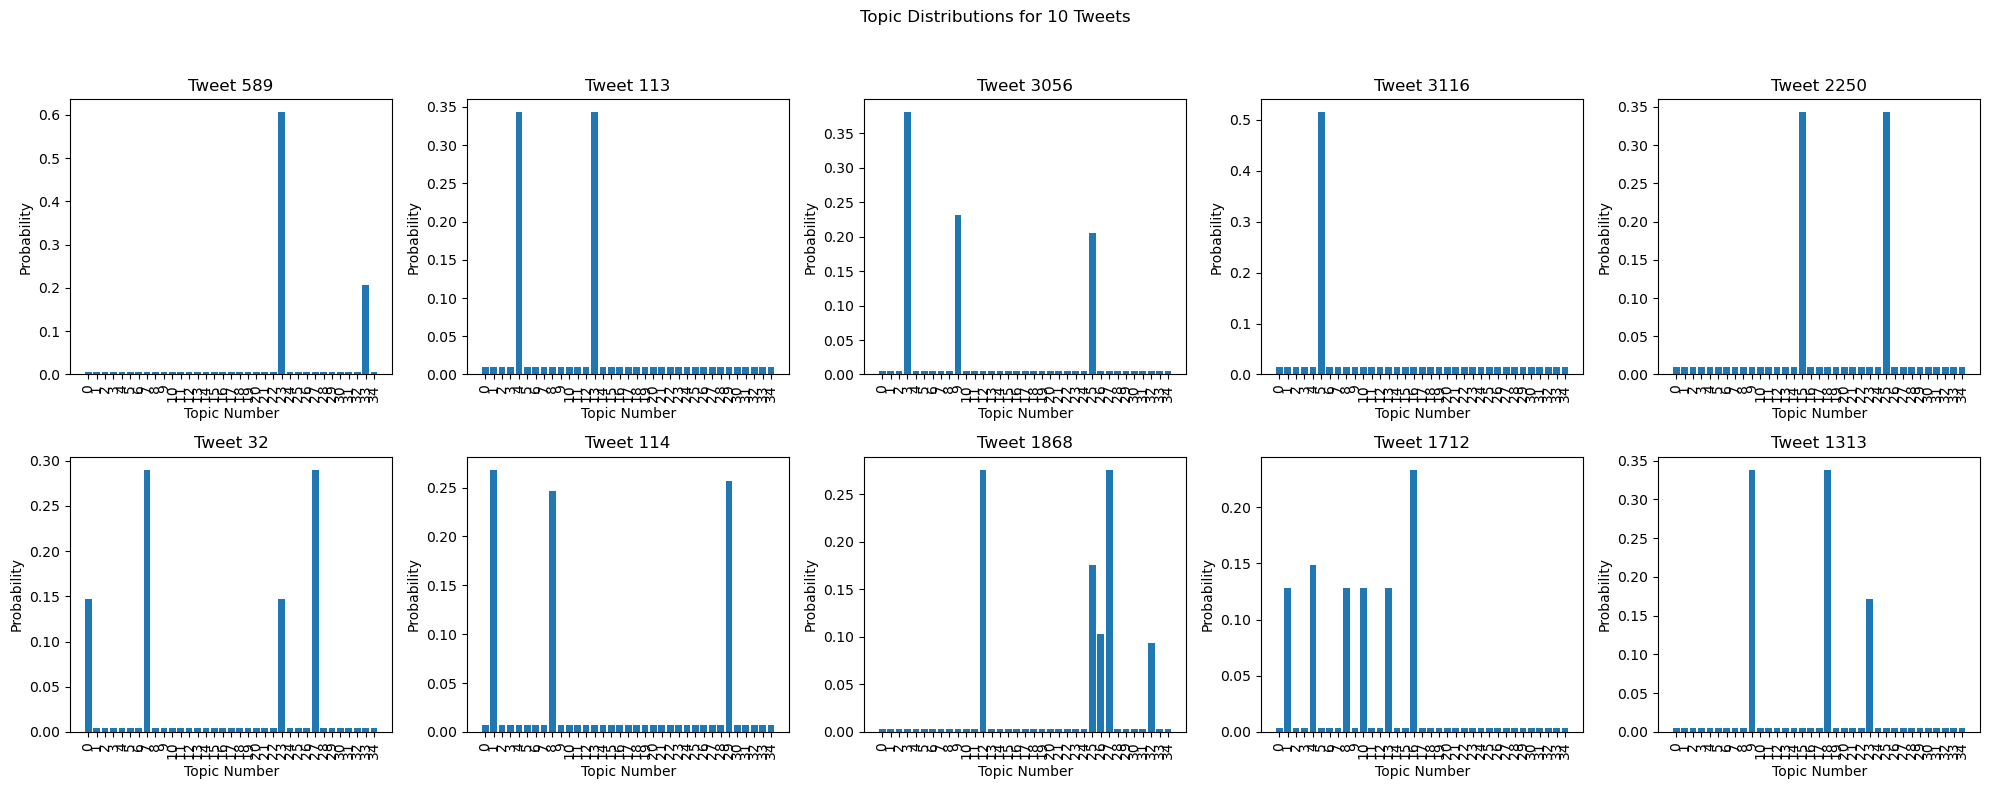

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the distribution of topics for 10 tweets as subplots
def plot_topic_distributions(lda_model, bow_corpus, num_tweets=10):
    num_topics = lda_model.num_topics

    # Randomly select 10 tweets (or the specified `num_tweets`) from the corpus
    selected_indices = np.random.choice(range(len(bow_corpus)), size=num_tweets, replace=False)
    selected_bows = [bow_corpus[i] for i in selected_indices]

    # Create a subplot grid of 2 rows by 5 columns
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle("Topic Distributions for 10 Tweets")

    # Loop over each selected tweet and create a topic distribution plot
    for idx, (bow, ax) in enumerate(zip(selected_bows, axs.flatten())):
        # Get the topic distribution for this tweet
        topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_nums, topic_probs = zip(*topics)

        # Plot the topic distribution
        ax.bar(topic_nums, topic_probs)
        ax.set_title(f'Tweet {selected_indices[idx]}')
        ax.set_xlabel('Topic Number')
        ax.set_ylabel('Probability')
        ax.set_xticks(range(num_topics))
        ax.set_xticklabels(range(num_topics), rotation =90)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


plot_topic_distributions(lda_model, bow_corpus)


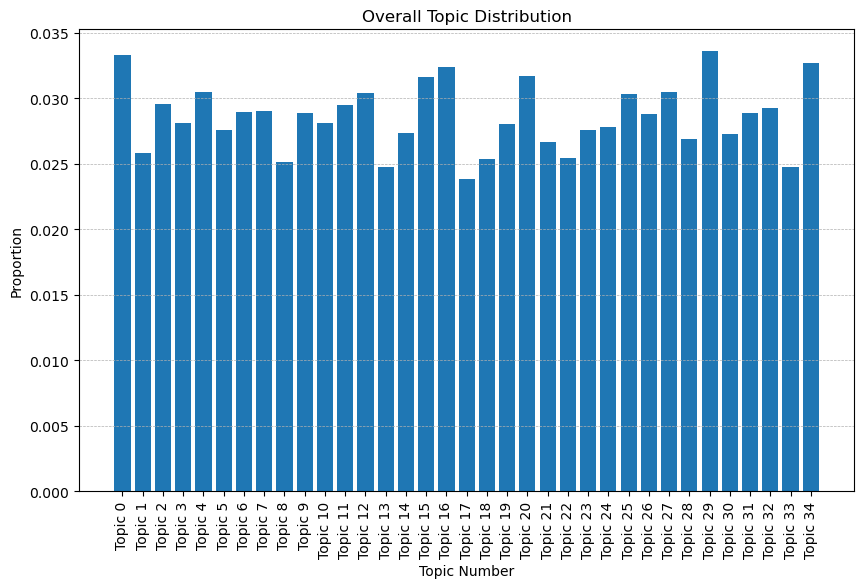

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the overall distribution of topics with vertical x-tick labels
def plot_overall_topic_distribution(lda_model, bow_corpus):
    num_topics = lda_model.num_topics
    # Initialize an array to hold the total probability for each topic
    topic_probs_sum = np.zeros(num_topics)

    # Accumulate topic probabilities across all documents
    for bow in bow_corpus:
        topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
        for topic_num, topic_prob in topics:
            topic_probs_sum[topic_num] += topic_prob

    # Normalize the probabilities to obtain a relative distribution
    topic_probs_sum /= np.sum(topic_probs_sum)

    # Plot the overall topic distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_topics), topic_probs_sum, tick_label=[f"Topic {i}" for i in range(num_topics)])
    plt.xlabel('Topic Number')
    plt.ylabel('Proportion')
    plt.title('Overall Topic Distribution')
    plt.xticks(range(num_topics), rotation=90)  # Rotate x-axis labels to vertical (90 degrees)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()


plot_overall_topic_distribution(lda_model, bow_corpus)


In [227]:
# Function to map labels to texts and their primary topics
def map_labels_to_primary_topics(lda_model, bow_corpus, labels, min_prob=0.2):
    """
    Maps each text to the most probable topic, given a minimum probability threshold.

    Parameters:
    - lda_model: The trained LDA model.
    - bow_corpus: Bag-of-words representation of the texts.
    - labels: List of labels corresponding to each text.
    - min_prob: Minimum probability threshold for topic relevance.

    Returns:
    - A mapping of labels to a list of primary topics.
    """
    label_topic_mapping = {0: [], 1: [], 2: [], 3: []}

    for i, bow in enumerate(bow_corpus):
        # Get all topics for the current document
        topics = lda_model.get_document_topics(bow, minimum_probability=min_prob)

        # Find the most probable topic above the minimum probability
        if topics:
            primary_topic = max(topics, key=lambda x: x[1])[0]
            label_topic_mapping[labels[i]].append(primary_topic)

    return label_topic_mapping

# Example usage
min_prob = 0.9  # Set a suitable probability threshold
label_topic_mapping = map_labels_to_primary_topics(lda_model, bow_corpus, train_labels, min_prob)

# Extract topics associated with "joy" and "optimism" (labels 1 and 2)
joy_optimism_topics = set(label_topic_mapping[1] + label_topic_mapping[2])
print(f"Topics associated with Joy and Optimism: {joy_optimism_topics}")



Topics associated with Joy and Optimism: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


In [239]:
import numpy as np

# Choose two documents for comparison
doc_idx_1 = 27  # Index of the first document
doc_idx_2 = 28  # Index of the second document

# Convert bag-of-words into dense vector for document 1
doc_1_vec = np.zeros(len(dictionary))
for idx, count in bow_corpus[doc_idx_1]:
    doc_1_vec[idx] = count

# Convert bag-of-words into dense vector for document 2
doc_2_vec = np.zeros(len(dictionary))
for idx, count in bow_corpus[doc_idx_2]:
    doc_2_vec[idx] = count

# Define cosine similarity function
def cossim(vec1, vec2):
    dot_prod = np.dot(vec1, vec2)
    normaliser = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return dot_prod / normaliser

# Calculate cosine similarity between the two documents
similarity = cossim(doc_1_vec, doc_2_vec)
print("Cosine Similarity between the two documents:", similarity)



Cosine Similarity between the two documents: 0.0


# BioCreative

In [6]:
ner_dataset = load_dataset(
    "tner/bc5cdr", 
)

print(f'The dataset is a dictionary with {len(ner_dataset)} splits: \n\n{ner_dataset}')

# It  may be useful to obtain the data in a list format for some sequence tagging methods
train_sentences_ner = [item['tokens'] for item in ner_dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['train']]

val_sentences_ner = [item['tokens'] for item in ner_dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['validation']]

test_sentences_ner = [item['tokens'] for item in ner_dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['test']]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5228
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5330
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5865
    })
})


In [13]:
ner_dataset["train"][2]

{'tokens': ['2', 'to', '2', 'mg', '/', 'kg', '.'],
 'tags': [0, 0, 0, 0, 0, 0, 0]}

In [61]:
ner_dataset["train"].features[f"tags"]

Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)

In [18]:
label_dict = {
    "O": 0,
    "B-Chemical": 1,
    "B-Disease": 2,
    "I-Disease": 3,
    "I-Chemical": 4
}
label_list = sorted(label_dict.keys())
label_list

['B-Chemical', 'B-Disease', 'I-Chemical', 'I-Disease', 'O']

In [19]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [20]:
show_random_elements(ner_dataset["train"])

,tokens,tags,pos_tags
0,"[Fatal, intracranial, bleeding, associated, with, prehospital, use, of, epinephrine, .]","[0, 2, 3, 0, 0, 0, 0, 0, 1, 0]","[2, 3, 4, 2, 2, 2, 2, 2, 1, 2]"
1,"[72, )., DISCUSSION, :, Quantifying, tremor]","[0, 0, 0, 0, 0, 2]","[2, 2, 2, 2, 2, 3]"
2,"[S, .]","[0, 0]","[2, 2]"
3,"[Passive, avoidance, paradigm, and, elevated, plus, maze, test, were, used, to, assess, cognitive, function, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
4,"[Recently, ,, synthetic, fibrinolysis, inhibitors, such, as, tranexamic, acid, (, tAMCA, ), have, been, considered, as, substitutes, for, aprotinin, .]","[0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
5,"[Attentional, modulation, of, perceived, pain, intensity, in, capsaicin, -, induced, secondary, hyperalgesia, .]","[0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0]","[2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2]"
6,"[RESULTS, :, Three, months, of, raloxifene, treatment, was, associated, with, a, significant, decrease, in, the, plasma, TAFI, antigen, concentrations, (, 16, %, change, ,, P, <, 0, .]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
7,"[2, g, /, dl, ,, splenomegaly, 2, -, 3, times, normal, ,, and, testicular, atrophy, approximately, half, normal, weight, ), after, 12, doses, of, carbon, tetrachloride, given, intragastrically, in, the, phenobarbitone, -, primed, rat, was, increased, from, 25, %, to, 56, %, by, giving, the, initial, "", calibrating, "", dose, of, carbon, tetrachloride, at, the, peak, of, the, phenobarbitone, -, induced, enlargement, of, the, liver, .]","[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 1, 0, 0, 2, 3, 3, 3, 0]","[2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 2, 2, 2, 2, 1, 2, 2, 3, 4, 4, 4, 2]"
8,"[In, order, that, this, syndrome, might, be, investigated, changes, in, mental, status, (, M, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
9,"[Various, ocular, symptoms, and, findings, caused, by, carboplatin, toxicity, were, seen, .]","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0]","[2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2]"


In [21]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "huawei-noah/TinyBERT_General_4L_312D" #"distilbert-base-uncased"

batch_size = 8

In [22]:
from transformers import AutoTokenizer
    
#tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) 
label_all_tokens=False

In [23]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [68]:
tokenizer(f"Hello, this is one sentence!")

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [69]:
tokenizer(["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."], is_split_into_words=True)

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 3975, 2046, 2616, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
example = ner_dataset["train"][4]
print(example["tokens"])

['Naloxone', 'alone', 'did', 'not', 'affect', 'either', 'blood', 'pressure', 'or', 'heart', 'rate', '.']


In [26]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['[CLS]', 'na', '##lo', '##xon', '##e', 'alone', 'did', 'not', 'affect', 'either', 'blood', 'pressure', 'or', 'heart', 'rate', '.', '[SEP]']


In [27]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example["tokens"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

17 17


In [64]:
#label_all_tokens = True

In [73]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, max_length=128, is_split_into_words=True)
    print(tokenized_inputs.keys())
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [74]:
tokenize_and_align_labels(ner_dataset['train'][:5])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


{'input_ids': [[101, 6583, 4135, 22500, 2063, 7901, 2015, 1996, 3424, 10536, 4842, 25808, 3512, 3466, 1997, 18856, 10698, 10672, 1012, 102], [101, 1999, 14477, 5267, 10760, 23355, 1010, 27491, 23760, 25808, 3512, 11432, 1996, 9885, 1999, 2668, 3778, 1998, 2540, 3446, 2550, 2011, 26721, 8159, 3560, 18856, 10698, 10672, 1010, 1019, 2000, 2322, 12702, 13113, 2015, 1013, 4705, 1010, 2001, 26402, 2098, 2030, 11674, 2011, 6583, 4135, 15975, 1010, 1014, 1012, 102], [101, 1016, 2000, 1016, 11460, 1013, 4705, 1012, 102], [101, 1996, 1044, 22571, 12184, 3619, 3512, 3466, 1997, 2531, 11460, 1013, 4705, 6541, 1011, 25003, 3527, 4502, 2001, 2036, 6822, 11674, 2011, 6583, 4135, 22500, 2063, 1012, 102], [101, 6583, 4135, 22500, 2063, 2894, 2106, 2025, 7461, 2593, 2668, 3778, 2030, 2540, 3446, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [75]:
tokenized_datasets = ner_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


Map:   0%|          | 0/5330 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


Map:   0%|          | 0/5865 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [76]:
# worksheet
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=5.7099185651951836e-05,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    no_cuda=True
)

/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/transformers/training_args.py:1376: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [78]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [43]:
pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/huggingface_hub-0.21.3-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f2d5e94c86dec0dbe56e85c841d31b86d24e6453548e9aad05d3a99f7e4c4074
  Stored in directory: /Users/joesouber/Library/Caches/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [79]:
metric = load_metric("seqeval")

/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_40908/152412463.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/datasets/load.py:752: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [80]:
labels = [label_list[i] for i in example["tags"]]
metric.compute(predictions=[labels], references=[labels])

{'Chemical': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 11},
 'Disease': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [81]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [82]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [83]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.246300,0.135196,0.946457,0.952292,0.949365,0.955831
2,0.130000,0.123983,0.953503,0.956908,0.955202,0.960882
3,0.096100,0.124009,0.955311,0.955117,0.955214,0.960476


Checkpoint destination directory TinyBERT_General_4L_312D-finetuned-ner/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory TinyBERT_General_4L_312D-finetuned-ner/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory TinyBERT_General_4L_312D-finetuned-ner/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1962, training_loss=0.13883970612536634, metrics={'train_runtime': 638.2229, 'train_samples_per_second': 24.574, 'train_steps_per_second': 3.074, 'total_flos': 26784889152000.0, 'train_loss': 0.13883970612536634, 'epoch': 3.0})

In [84]:
trainer.evaluate()

{'eval_loss': 0.13045839965343475,
 'eval_precision': 0.9489875803411781,
 'eval_recall': 0.9501722536192614,
 'eval_f1': 0.9495795474876815,
 'eval_accuracy': 0.956365446300188,
 'eval_runtime': 46.5336,
 'eval_samples_per_second': 114.541,
 'eval_steps_per_second': 28.646,
 'epoch': 3.0}

In [84]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'Chemical': {'precision': 0.9687010349163362,
  'recall': 0.965367673282119,
  'f1': 0.967031481579824,
  'number': 103747},
 'Disease': {'precision': 0.7810877288876742,
  'recall': 0.8026962505266114,
  'f1': 0.7917445806496294,
  'number': 7121},
 'overall_precision': 0.9562994544206381,
 'overall_recall': 0.9549193635674856,
 'overall_f1': 0.9556089107123515,
 'overall_accuracy': 0.961189889557022}

In [87]:
import numpy as np
from IPython.display import display, HTML
import pandas as pd

# Function to show mislabeled sentences and provide suggestions for improvement
def show_mislabelled_sentences(trainer, tokenized_dataset, label_list, num_examples=5):
    """
    Displays examples of mislabeled sentences and provides suggestions for improvement.

    Args:
        trainer (Trainer): Trained Hugging Face Trainer object.
        tokenized_dataset (Dataset): Tokenized dataset used for evaluation.
        label_list (list): List of labels used in the dataset.
        num_examples (int): Number of mislabelled examples to show.
    """
    # Get predictions from the model
    predictions, labels, _ = trainer.predict(tokenized_dataset)
    predictions = np.argmax(predictions, axis=2)

    # Mapping predictions and labels back to their human-readable tags
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Identify indices of mislabeled sentences
    mislabelled_indices = [
        idx for idx, (pred, truth) in enumerate(zip(true_predictions, true_labels)) if pred != truth
    ]

    # Collect examples of mislabelled sentences
    mislabelled_examples = []
    for idx in mislabelled_indices[:num_examples]:
        sentence_tokens = tokenized_dataset[idx]["tokens"]
        pred_labels = true_predictions[idx]
        true_labels_seq = true_labels[idx]

        mislabelled_examples.append({
            "Tokens": " ".join(sentence_tokens),
            "Predicted Labels": " ".join(pred_labels),
            "True Labels": " ".join(true_labels_seq)
        })

    # Display mislabelled examples as a DataFrame
    df = pd.DataFrame(mislabelled_examples)
    display(HTML(df.to_html(index=False)))

   


In [88]:
show_mislabelled_sentences(trainer, tokenized_datasets["validation"], label_list, num_examples=5)


Tokens,Predicted Labels,True Labels
Tricuspid valve regurgitation and lithium carbonate toxicity in a newborn infant .,B-Chemical B-Chemical B-Chemical B-Chemical B-Disease O I-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical,I-Chemical I-Disease I-Disease B-Chemical B-Disease O I-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical
"This is the first patient to initially manifest tricuspid regurgitation and atrial flutter , and the 11th described patient with cardiac disease among infants exposed to lithium compounds in the first trimester of pregnancy .",B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical I-Disease B-Chemical I-Chemical I-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical I-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Disease O B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical,B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical I-Disease B-Chemical I-Chemical I-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical I-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical
A 2 - year - old child with known neurologic impairment developed a dyskinesia soon after starting phenobarbital therapy for seizures .,B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical I-Disease B-Chemical B-Chemical I-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical B-Chemical,B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical I-Disease B-Chemical B-Chemical I-Chemical B-Chemical B-Chemical B-Chemical B-Disease B-Chemical B-Chemical I-Chemical B-Chemical
Acute changes of blood ammonia may predict short - term adverse effects of valproic acid .,B-Chemical B-Chemical B-Chemical B-Disease O B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Disease O B-Chemical,B-Chemical B-Chemical B-Chemical B-Chemical B-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Disease O B-Chemical
"A standardized loading dose of VPA was administered , and venous blood was sampled at 0 , 1 , 2 , 3 , and 4 hours .",B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Disease B-Chemical B-Chemical B-Chemical B-Chemical I-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical,B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Disease B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical B-Chemical



**Suggestions for Improvement:**
- **Data Augmentation:** Increase training data diversity with more annotated sentences.
- **Label Smoothing:** Introduce label smoothing to help the model generalize better.
- **Model Fine-tuning:** Experiment with different pre-trained models to identify the most suitable one.
- **Hyperparameter Tuning:** Adjust learning rates, batch sizes, and other hyperparameters to improve performance.


In [90]:
pip install optuna

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/huggingface_hub-0.21.3-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 6.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [91]:
import optuna
from transformers import Trainer, TrainingArguments, AutoModelForTokenClassification

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    # Training arguments with suggested hyperparameters
    args = TrainingArguments(
        output_dir="results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=3,
        weight_decay=0.01,
        no_cuda=True
    )

    # Initialize the model
    model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
    
    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Run training and return evaluation metric
    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results["eval_loss"]

# Optimize with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_params = study.best_params
print(f"Best parameters: {best_params}")


[I 2024-05-08 15:40:37,262] A new study created in memory with name: no-name-6ec83b41-1b2c-4fda-91b8-e0b431aaf1fa
/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_16046/1006553414.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/transformers/training_args.py:1376: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to us

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.282300,0.151651,0.940095,0.950985,0.945509,0.952264
2,0.157100,0.131730,0.948988,0.954672,0.951821,0.958255
3,0.122800,0.129166,0.951228,0.951256,0.951242,0.957481


[I 2024-05-08 15:51:38,222] Trial 0 finished with value: 0.12916643917560577 and parameters: {'learning_rate': 3.277472604781392e-05, 'batch_size': 8}. Best is trial 0 with value: 0.12916643917560577.
/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_16046/1006553414.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/transformers/training_args.py:1376: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifi

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.154635,0.940845,0.944405,0.942621,0.950061
2,No log,0.128916,0.952123,0.951653,0.951888,0.958384
3,No log,0.125445,0.954207,0.953792,0.953999,0.959287


[I 2024-05-08 16:04:36,094] Trial 1 finished with value: 0.12544472515583038 and parameters: {'learning_rate': 0.00010027563134746691, 'batch_size': 32}. Best is trial 1 with value: 0.12544472515583038.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.275915,0.900208,0.914599,0.907346,0.916261
2,0.395300,0.230100,0.921011,0.918034,0.919520,0.929469
3,0.395300,0.217446,0.925411,0.925089,0.925250,0.935009


Checkpoint destination directory results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[I 2024-05-08 16:16:12,743] Trial 2 finished with value: 0.21744588017463684 and parameters: {'learning_rate': 1.0799029138711414e-05, 'batch_size': 16}. Best is trial 1 with value: 0.12544472515583038.
/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_16046/1006553414.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/transformers/training_args.py:1376: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.241600,0.134186,0.947941,0.951363,0.949649,0.955766
2,0.128700,0.121042,0.954277,0.957537,0.955904,0.961619
3,0.095100,0.123693,0.955066,0.953975,0.954520,0.959997


Checkpoint destination directory results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[I 2024-05-08 16:42:41,820] Trial 3 finished with value: 0.12369299679994583 and parameters: {'learning_rate': 5.7099185651951836e-05, 'batch_size': 8}. Best is trial 3 with value: 0.12369299679994583.
/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_16046/1006553414.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/transformers/training_args.py:1376: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classif

Epoch,Training Loss,Validation Loss


Checkpoint destination directory results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[W 2024-05-08 16:45:16,042] Trial 4 failed with parameters: {'learning_rate': 0.0002473660012746326, 'batch_size': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_16046/1006553414.py", line 35, in objective
    trainer.train()
  File "/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/transformers/trainer.py", line 1624, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/transformers/trainer.py", 

KeyboardInterrupt: 

In [93]:
best_params = study.best_params
print(f"Best parameters: {best_params}")


Best parameters: {'learning_rate': 5.7099185651951836e-05, 'batch_size': 8}


# BERT+POS+CRF

In [28]:
import nltk
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('punkt')  # For sentence tokenization




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joesouber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/joesouber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
conda install python-crfsuite

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [29]:
from nltk.tag import CRFTagger
from nltk import pos_tag

# Create an instance of the CRFTagger
crf_tagger = CRFTagger()

# Function to prepare training data with POS tags
def prepare_training_data_with_pos(dataset):
    training_data = []
    for item in dataset:
        tokens = item['tokens']
        entity_tags = item['tags']
        tokens_with_pos = pos_tag(tokens)
        # Combine POS tags and NER tags into a training format
        training_sequence = [(token, f'{pos_tag}/{entity_tag}') for (token, pos_tag), entity_tag in zip(tokens_with_pos, entity_tags)]
        training_data.append(training_sequence)
    return training_data

# Prepare training data from your specific dataset split
train_data = prepare_training_data_with_pos(ner_dataset['train'])

# Train the CRF tagger
crf_tagger.train(train_data, 'crf_model.crf.tagger')


In [11]:
%whos

Variable                         Type           Data/Info
---------------------------------------------------------
CRFTagger                        ABCMeta        <class 'nltk.tag.crf.CRFTagger'>
build_pos_vocab                  function       <function build_pos_vocab at 0x14ddb91c0>
convert_pos_tags_to_indices      function       <function convert_pos_tag<...>o_indices at 0x13bbe5620>
crf_tagger                       CRFTagger      <nltk.tag.crf.CRFTagger object at 0x14ddc1090>
load_dataset                     function       <function load_dataset at 0x14aab4f40>
load_metric                      function       <function load_metric at 0x14aab4ea0>
ner_dataset                      DatasetDict    DatasetDict({\n    train:<...>um_rows: 5865\n    })\n})
nltk                             module         <module 'nltk' from '/Use<...>ckages/nltk/__init__.py'>
np                               module         <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
pos_tag                      

In [30]:
# Create a mapping of POS tags to integer indices
def build_pos_vocab(pos_tagged_dataset):
    pos_vocab = {}
    index = 1  # Start indexing from 1 to leave 0 for padding
    for split in ['train', 'validation', 'test']:
        for example in pos_tagged_dataset[split]:
            for tag in example['pos_tags']:
                if tag not in pos_vocab:
                    pos_vocab[tag] = index
                    index += 1
    return pos_vocab

# Create the POS vocabulary
pos_vocab = build_pos_vocab(ner_dataset)


{1: 1, 0: 2, 2: 3, 3: 4, 4: 5}

In [31]:
# Function to convert POS tags from strings to numerical indices
def convert_pos_tags_to_indices(example, pos_vocab):
    example['pos_tags'] = [pos_vocab.get(tag, 0) for tag in example['pos_tags']]  # Default to 0 if not found
    return example

# Apply the function to the entire dataset
ner_dataset['train'] = ner_dataset['train'].map(lambda x: convert_pos_tags_to_indices(x, pos_vocab))
ner_dataset['validation'] = ner_dataset['validation'].map(lambda x: convert_pos_tags_to_indices(x, pos_vocab))
ner_dataset['test'] = ner_dataset['test'].map(lambda x: convert_pos_tags_to_indices(x, pos_vocab))


Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/5330 [00:00<?, ? examples/s]

Map:   0%|          | 0/5865 [00:00<?, ? examples/s]

In [33]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")



def tokenize_and_align_labels_and_pos(examples):
    max_length = 128
    tokenized_inputs = tokenizer(
        examples['tokens'],
        is_split_into_words=True,
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    
    labels = []
    pos_tags_aligned = []
    for i, (ner_tags, pos_tags) in enumerate(zip(examples['tags'], examples['pos_tags'])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        pos_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
                pos_ids.append(0)  # Use 0 as the padding value for POS tags
            elif word_idx != previous_word_idx:
                label_ids.append(ner_tags[word_idx])
                pos_ids.append(pos_tags[word_idx])
            else:
                label_ids.append(ner_tags[word_idx] if label_all_tokens else -100)
                pos_ids.append(pos_tags[word_idx] if label_all_tokens else 0)
            previous_word_idx = word_idx
        labels.append(label_ids)
        pos_tags_aligned.append(pos_ids)

    tokenized_inputs['labels'] = torch.nn.utils.rnn.pad_sequence([torch.tensor(label) for label in labels], batch_first=True, padding_value=-100)
    tokenized_inputs['pos_tags'] = torch.nn.utils.rnn.pad_sequence([torch.tensor(pos) for pos in pos_tags_aligned], batch_first=True, padding_value=0)

    return tokenized_inputs



In [34]:
# Ensure your NER dataset is available and mapped with tokenization
tokenized_datasets = ner_dataset.map(tokenize_and_align_labels_and_pos, batched=True)

Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/5330 [00:00<?, ? examples/s]

Map:   0%|          | 0/5865 [00:00<?, ? examples/s]

In [35]:
import torch
from torch import nn
from transformers import AutoModel


class BertWithPOS(nn.Module):
    def __init__(self, model_name, num_labels, pos_vocab_size, pos_embedding_dim=32):
        super(BertWithPOS, self).__init__()
        self.num_labels = num_labels  # Add this attribute to the model
        self.bert = AutoModel.from_pretrained(model_name)
        self.pos_embedding = nn.Embedding(pos_vocab_size, pos_embedding_dim)
        # Concatenate the BERT embeddings with POS embeddings
        self.classifier = nn.Linear(self.bert.config.hidden_size + pos_embedding_dim, num_labels)

    def forward(self, input_ids, attention_mask=None, pos_tags=None, labels=None):
        # Obtain BERT embeddings
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_outputs.last_hidden_state

        # POS Embedding Layer
        pos_embeddings = self.pos_embedding(pos_tags)

        # Concatenate BERT and POS embeddings
        combined_embeddings = torch.cat([bert_embeddings, pos_embeddings], dim=-1)

        # Apply classification layer
        logits = self.classifier(combined_embeddings)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            # Flatten predictions and labels for loss calculation
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fn(active_logits, active_labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}


In [36]:
from transformers import TrainingArguments, Trainer

# Define the model, assuming num_labels and other parameters are already set
model = BertWithPOS(model_checkpoint, num_labels=len(label_list), pos_vocab_size=50, pos_embedding_dim=32)

# Update training arguments if necessary
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5.7099185651951836e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Now, use the tokenized_datasets as input to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],  # Ensure this key exists
    eval_dataset=tokenized_datasets["validation"],  # Ensure this key exists
    tokenizer=tokenizer,
    data_collator=None  # Use the default data collator
)



# Train the model
trainer.train()


/Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.187300,0.086180
2,0.076200,0.065209
3,0.048700,0.061845


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1962, training_loss=0.08773320263192802, metrics={'train_runtime': 411.3342, 'train_samples_per_second': 38.13, 'train_steps_per_second': 4.77, 'total_flos': 0.0, 'train_loss': 0.08773320263192802, 'epoch': 3.0})

In [37]:
import numpy as np
from seqeval.metrics import classification_report

# Ensure the test dataset is tokenized and aligned
tokenized_test_dataset = ner_dataset['test'].map(tokenize_and_align_labels_and_pos, batched=True)

# Run the `predict` method to get predictions and labels
test_results = trainer.predict(tokenized_test_dataset)

# Extract predictions and actual labels
predictions = test_results.predictions
labels = test_results.label_ids

# Apply argmax to convert logits to predicted class indices
predicted_indices = np.argmax(predictions, axis=2)


label_dict = {
    "O": 0,
    "B-Chemical": 1,
    "B-Disease": 2,
    "I-Disease": 3,
    "I-Chemical": 4
}
label_list = sorted(label_dict.keys())

# Map numeric indices to string labels for predicted and actual values
true_predictions = [
    [label_list[pred] for pred, actual in zip(predictions, actuals) if actual != -100]
    for predictions, actuals in zip(predicted_indices, labels)
]

true_labels = [
    [label_list[actual] for pred, actual in zip(predictions, actuals) if actual != -100]
    for predictions, actuals in zip(predicted_indices, labels)
]

# Generate and print the classification report
report = classification_report(true_labels, true_predictions)
print(report)



Map:   0%|          | 0/5865 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    Chemical       0.98      0.98      0.98    103747
     Disease       0.86      0.88      0.87      7121

   micro avg       0.97      0.97      0.97    110868
   macro avg       0.92      0.93      0.92    110868
weighted avg       0.97      0.97      0.97    110868



In [40]:
# Identify misclassified sentences
misclassified_sentences = []
for i, (pred, actual) in enumerate(zip(true_predictions, true_labels)):
    if pred != actual:
        original_sentence = ner_dataset['test'][i]['tokens']  # Assuming your dataset contains original tokens
        misclassified_sentences.append({
            "sentence": original_sentence,
            "predictions": pred,
            "actual": actual
        })

# Print the misclassified sentences
for idx, misclassified in enumerate(misclassified_sentences):
    print(f"Misclassified Sentence {idx + 1}:")
    print("Tokens:", misclassified["sentence"])
    print("Predictions:", misclassified["predictions"])
    print("Actual:", misclassified["actual"])
    print()

Misclassified Sentence 1:
Tokens: ['Famotidine', 'is', 'a', 'histamine', 'H2', '-', 'receptor', 'antagonist', 'used', 'in', 'inpatient', 'settings', 'for', 'prevention', 'of', 'stress', 'ulcers', 'and', 'is', 'showing', 'increasing', 'popularity', 'because', 'of', 'its', 'low', 'cost', '.']
Predictions: ['B-Disease', 'B-Chemical', 'B-Chemical', 'B-Disease', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'I-Disease', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical']
Actual: ['B-Disease', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'I-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-Chemical', 'B-

# CRF +POS

In [85]:
pip install nltk sklearn_crfsuite


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /Users/joesouber/opt/anaconda3/envs/text_analytics/lib/python3.11/site-packages/huggingface_hub-0.21.3-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [97]:
import nltk
from nltk.tag import CRFTagger
from sklearn_crfsuite import metrics

# Download required NLTK resources for POS tagging
nltk.download('averaged_perceptron_tagger')

# Function to add POS tags to the dataset
def add_pos_tags(example):
    tokens = example['tokens']
    pos_tags = [tag for _, tag in nltk.pos_tag(tokens)]
    example['pos_tags'] = pos_tags
    return example

# Function to convert the dataset to CRFTagger format with string labels
def prepare_crf_data(dataset):
    crf_data = []
    for item in dataset:
        tokens = item['tokens']
        tags = [str(tag) for tag in item['tags']]  # Ensure labels are strings
        crf_data.append(list(zip(tokens, tags)))
    return crf_data

# Apply POS tagging to your dataset (replace with your dataset variable)
ner_dataset['train'] = ner_dataset['train'].map(add_pos_tags)
ner_dataset['validation'] = ner_dataset['validation'].map(add_pos_tags)

# Prepare training and validation data
train_data = prepare_crf_data(ner_dataset['train'])
val_data = prepare_crf_data(ner_dataset['validation'])

# Initialize the CRFTagger and train the model
crf_tagger = CRFTagger()
crf_tagger.train(train_data, 'crf_model.crf.tagger')

# Extract tokens from the validation dataset for predictions
val_tokens = [[token for token, _ in sent] for sent in val_data]

# Predict the labels using the CRF model
predictions = [crf_tagger.tag(tokens) for tokens in val_tokens]

# Extract true labels for validation evaluation
val_true_labels = [[tag for _, tag in sent] for sent in val_data]

# Convert predictions to only the tags (labels) for evaluation
y_pred = [[tag for _, tag in pred] for pred in predictions]



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joesouber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/5330 [00:00<?, ? examples/s]

In [98]:
from sklearn.metrics import classification_report
from sklearn_crfsuite import metrics

# Flatten the lists of lists into one list each for true and predicted labels
y_true_flat = [label for seq in val_true_labels for label in seq]
y_pred_flat = [label for seq in y_pred for label in seq]

# Generate the classification report
report = classification_report(y_true_flat, y_pred_flat, digits=3)
print(report)


              precision    recall  f1-score   support

           0      0.964     0.991     0.977     96413
           1      0.907     0.783     0.841      5347
           2      0.833     0.600     0.698      4244
           3      0.722     0.532     0.612      2416
           4      0.822     0.576     0.678       538

    accuracy                          0.953    108958
   macro avg      0.850     0.696     0.761    108958
weighted avg      0.950     0.953     0.950    108958



# CRF+POS extended

In [103]:
import nltk
from nltk.tag import CRFTagger
from sklearn_crfsuite import metrics

# Download required NLTK resources for POS tagging
nltk.download('averaged_perceptron_tagger')

# Function to add POS tags to the dataset
def add_pos_tags(example):
    tokens = example['tokens']
    pos_tags = [tag for _, tag in nltk.pos_tag(tokens)]
    example['pos_tags'] = pos_tags
    return example

# Function to extract features for each token (with additional features)
def extract_features(tokens, pos_tags, index):
    token = tokens[index]
    pos_tag = pos_tags[index]

    # Base features
    features = {
        'token.lower()': token.lower(),
        'token[-3:]': token[-3:],  # Last 3 characters
        'token[-2:]': token[-2:],  # Last 2 characters
        'token.isupper()': token.isupper(),
        'token.istitle()': token.istitle(),
        'token.isdigit()': token.isdigit(),
        'pos_tag': pos_tag
    }

    # Prefix features
    if len(token) > 3:
        features['token[:3]'] = token[:3]
    if len(token) > 2:
        features['token[:2]'] = token[:2]

    # Contextual features: previous and next tokens/pos tags
    if index > 0:
        prev_token = tokens[index - 1]
        prev_pos = pos_tags[index - 1]
        features.update({
            'prev_token.lower()': prev_token.lower(),
            'prev_pos_tag': prev_pos,
        })
    else:
        features['BOS'] = True  # Beginning of the sentence

    if index < len(tokens) - 1:
        next_token = tokens[index + 1]
        next_pos = pos_tags[index + 1]
        features.update({
            'next_token.lower()': next_token.lower(),
            'next_pos_tag': next_pos,
        })
    else:
        features['EOS'] = True  # End of the sentence

    return features

# Function to prepare CRF training data with extended features
def prepare_crf_data(dataset):
    crf_data = []
    for item in dataset:
        tokens = item['tokens']
        pos_tags = item['pos_tags']
        tags = [str(tag) for tag in item['tags']]  # Ensure labels are strings
        # Extract features for each token and combine them with tags
        features_sequence = [extract_features(tokens, pos_tags, idx) for idx in range(len(tokens))]
        training_sequence = list(zip(features_sequence, tags))
        crf_data.append(training_sequence)
    return crf_data

# Apply POS tagging to your dataset (replace with your dataset variable)
ner_dataset['train'] = ner_dataset['train'].map(add_pos_tags)
ner_dataset['validation'] = ner_dataset['validation'].map(add_pos_tags)

# Prepare training and validation data
train_data = prepare_crf_data(ner_dataset['train'])
val_data = prepare_crf_data(ner_dataset['validation'])

# Modify the CRFTagger class definition to include the _get_features method
class CRFTagger:
    def __init__(self):
        # Initialize your CRFTagger class here
        pass

    def train(self, train_data, model_file):
        # Your training logic here
        pass

    def _get_features(self, tokens, idx):
        token = tokens[idx]
        feature_list = []

        # Check if the token is not empty
        if token:
            # Capitalization
            if token[0].isupper():
                feature_list.append("CAPITALIZATION")
            # Number
            if token.isdigit():
                feature_list.append("NUMBER")
            # Other features...
            # Add more features as needed

        return feature_list

# Initialize the CRFTagger and train the model
crf_tagger = CRFTagger()
crf_tagger.train(train_data, 'crf_model.crf.tagger')

# Extract tokens from the validation dataset for predictions
val_tokens = [[feature for feature, _ in sent] for sent in val_data]

# Predict the labels using the CRF model
predictions = [crf_tagger.tag(tokens) for tokens in val_tokens]

# Extract true labels for validation evaluation
val_true_labels = [[tag for _, tag in sent] for sent in val_data]

# Convert predictions to only the tags (labels) for evaluation
y_pred = [[tag for _, tag in pred] for pred in predictions]

# # Generate the classification report
# report = metrics.flat_classification_report(val_true_labels, y_pred, digits=3)
# print(report)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joesouber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/5330 [00:00<?, ? examples/s]

AttributeError: 'CRFTagger' object has no attribute 'tag'

NameError: name 'true_predictions' is not defined